# Using PySINDy

PySINDy is a package for equation learning, with many example uses: https://pysindy.readthedocs.io/en/latest/examples/


**Instructions**:


*   Run Installations and all sub-cells. This will involve restart of the runtime for both pysindy and fenics.
*   Choose section and run from there. Currently these are


1.   pySINDy ODE example
2.   pySINDY PDE example (2-D reaction diffusion)
3.   PDEFIND on a reaction diffusion system with Schnakenberg kinetics





# Installations

## Install FeNiCs and PySINDy - rerun cell after kernel kill

In [ ]:
try:
    import pysindy

except ImportError:

  !pip install pysindy
  # Restart runtime

atry:
    import dolfin

except ImportError:

    !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

--2023-05-03 14:22:40--  https://fem-on-colab.github.io/releases/fenics-install.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4156 (4.1K) [application/x-sh]
Saving to: ‘/tmp/fenics-install.sh’

/tmp/fenics-install 100%[===================>]   4.06K  --.-KB/s    in 0s      

2023-05-03 14:22:40 (34.0 MB/s) - ‘/tmp/fenics-install.sh’ saved [4156/4156]

+ INSTALL_PREFIX=/usr/local
++ echo /usr/local
++ awk -F/ '{print NF-1}'
+ INSTALL_PREFIX_DEPTH=2
+ PROJECT_NAME=fem-on-colab
+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ FENICS_INSTALLED=/usr/local/share/fem-on-colab/fenics.installed
+ [[ ! -f /usr/local/share/fem-on-colab/fenics.installed ]]
+ PYBIND11_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/6895377/releases/pybind11-install.s

## Imports and settings

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import pysindy as ps
import copy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.linear_model import Lasso
from scipy.io import loadmat
from sklearn.metrics import mean_squared_error
from scipy.integrate import solve_ivp

from dolfin import *
from fenics import *
import numpy as np
import numpy.random
import matplotlib.pyplot as plt
import time

# Ignore matplotlib deprecation warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Seed the random number generators for reproducibility
np.random.seed(100)

integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['atol'] = 1e-12

from numpy.fft import fft2, ifft2
integrator_keywords['method'] = 'RK45'  # switch to RK45 integrator

# These lines suppress FeNiCs output which is quite verbose - if something isn't working
# comment these out to see warnings etc.

# import logging
# logging.getLogger('FFC').setLevel(logging.ERROR)
# logging.getLogger('UFL').setLevel(logging.ERROR)
# logging.getLogger('DOLFIN').setLevel(logging.ERROR)

# These lines should enable FeNiCs output originally - but doesn't seem to work as intended,
# instead disconnect and delete runtime and start again

# import logging
# logging.getLogger('FFC').setLevel(logging.INFO)
# logging.getLogger('UFL').setLevel(logging.INFO)
# logging.getLogger('DOLFIN').setLevel(logging.INFO)

In [ ]:
from datetime import date as dt
import pickle as pkl

def save_solution(array_save_path, exp_name, array):
    today = dt.today()
    date = today.strftime("%b-%d-%Y")

    os.makedirs(path + '/{}_{}'.format(exp_name, date), exist_ok=True)
    # array_save_path = (path + '/{}_{}.pkl'.format(exp_name, date))
    to_save = array

    with open(array_save_path, 'wb') as pickle_file:
        pkl.dump(to_save, pickle_file)
    with open(array_save_path, 'rb') as pickle_file:
        saved_array = pkl.load(pickle_file)
    return saved_array

def load_array(save_path):
    with open(save_path, 'rb') as pickle_file:
        saved_array = pkl.load(pickle_file)

    return saved_array


# 1: PySINDy ODE example:

## Main ideas
Suppose we have a set of measurements $x(t)\in \mathbb{R}^n$ from some physical system at different points in time $t$. SINDy seeks to represent the time evolution of $x(t)$ in terms of a nonlinear function $f$:

$$ \frac{d}{dt}x(t) = f(x(t)). $$

This equation constitutes a *dynamical system* for the measurements $x(t)$. The vector $x(t)=[x_1(t), x_2(t), \dots x_n(t)]^\top$ gives the state of the physical system at time $t$. The function $f(x(t))$ constrains how the system evolves in time.

The key idea behind SINDy is that the function $f$ is often **sparse** in the space of an appropriate set of basis functions. For example, the function

$$
	\frac{d}{dt}x = f(x)
	= \begin{bmatrix} f_1(x)\\f_2(x) \end{bmatrix}
	= \begin{bmatrix}1 - x_1 + 3x_1x_2 \\ x_2^2 - 5x_1^3 \end{bmatrix}
$$

is sparse with respect to the set of polynomials of two variables in the sense that if we were to write an expansion of the component functions of $f$ in this basis (e.g. $f_{1}(x) = \sum_{i=0}^\infty\sum_{j=0}^\infty a_{i,j}x_1^ix_2^j$), only a small number of coefficients ($a_{i,j}$) would be nonzero.

SINDy employs **sparse regression** to find a linear combination of basis functions that best capture the dynamic behavior of the physical system.

## sparse function definition

*If a function is sparse in a space of an appropriate set of basis functions, it means that the function can be represented by a small number of non-zero coefficients with respect to that basis.*

## Approximation problem
To apply SINDy in practice one needs a set of measurement data collected at times $t_1, t_2, \dots, t_n$, and the time derivatives of these measurements (either measured directly or numerically approximated). These data are aggregated into the matrices $X$ and $\dot X$, respectively

$$
	X = \begin{bmatrix}
		x_1(t_1) & x_2(t_1) & \dots & x_n(t_1) \\
		x_1(t_2) & x_2(t_2) & \dots & x_n(t_2) \\
		\vdots & \vdots & & \vdots \\ x_1(t_m) & x_2(t_m) & \dots & x_n(t_m)
	\end{bmatrix},
	\qquad
	\dot{X} = \begin{bmatrix} \dot{x_1}(t_1) & \dot{x_2}(t_1) & \dots & \dot{x_n}(t_1) \\
		\dot{x_1}(t_2) & \dot{x_2}(t_2) & \dots & \dot{x_n}(t_2) \\
		\vdots & \vdots & & \vdots \\
		\dot{x_1}(t_m) & \dot{x_2}(t_m) & \dots & \dot{x_n}(t_m)
	\end{bmatrix}.
$$

Next, one forms a library matrix $\Theta(X)$ whose columns consist of a chosen set of basis functions applied to the data

$$
	\Theta(X) = \begin{bmatrix}
		\mid & \mid & & \mid \\
		\theta_1(X) & \theta_2(X) & \dots & \theta_\ell(X) \\
		\mid & \mid & & \mid
	\end{bmatrix}.
$$

For example, if $\theta_1(x), \theta_2(x), \dots, \theta_\ell(x)$ are monomials ($\theta_i(x) = x^{i-1}$), then

$$
	\theta_3(X) = \begin{bmatrix}
		\mid & \mid & & \mid & \mid & & \mid \\
		x_1(t)^2 & x_1(t)x_2(t) & \dots & x_2(t)^2 & x_2(t)x_3(t) & \dots & x_n^2(t) \\
		\mid & \mid & & \mid & \mid & & \mid
	\end{bmatrix},
$$

where vector products and powers are understood to be element-wise.

We seek a set of sparse coefficient vectors (collected into a matrix)

$$
	\Xi = \begin{bmatrix}
		\mid & \mid & & \mid \\
		\xi_1 & \xi_2 & \dots & \xi_n \\
		\mid & \mid & & \mid
	\end{bmatrix}.
$$

The vector $\xi_i$ provides the coefficients for a linear combination of basis functions $\theta_1(x), \theta_2(x), \dots, \theta_\ell(x)$ representing the $i$th component function of $f$: $f_i(x)$. That is to say, $f_i(x) = \Theta\left(x^\top\right) \xi_i$, where $\Theta\left(x^\top\right)$ is understood to be a row vector consisting of symbolic functions (whereas $\Theta(X)$ is a matrix whose entries are numerical values).

With each of the objects $X$, $\dot X$, $\Theta(X)$, and $\Xi$ being defined, we are ready to write down the approximation problem underlying SINDy:

$$ \dot X \approx \Theta(X)\Xi. $$

## Structure of PySINDy
The submodules of PySINDy are each aligned with one of the terms in the aforementioned approximation equation

$$ \dot X \approx \Theta(X)\Xi. $$

 * `pysindy.differentiate` performs numerical differentiation to compute $\dot X$ from $X$;
 * `pysindy.feature_library` allows the user to specify a set of library functions and handles the formation of $\Theta(X)$;
 * `pysindy.optimizers` provides a set of sparse regression solvers for determining $\Xi$.

The `SINDy` object encapsulates one class object from each of these three submodules and uses them, along with a user-supplied data matrix, to find a governing dynamical system.

Let's walk through an example showing how this works using a toy dataset.

## Example
Suppose we have measurements of the position of a particle obeying the following dynamical system at different points in time:

$$
	\frac{d}{dt} \begin{bmatrix} x \\ y \end{bmatrix}
	= \begin{bmatrix} -2x \\ y \end{bmatrix}
	= \begin{bmatrix} -2 & 0 \\ 0 & 1 \end{bmatrix}
	\begin{bmatrix} x \\ y \end{bmatrix}
$$

Note that this system of differential equations decouples into two differential equations whose solutions are simply $x(t) = x_0e^{-2t}$ and $y(t) = y_0e^t$, where $x_0 = x(0)$ and $y_0=y(0)$ are the initial conditions.

Using the initial conditions $x_0 = 3$ and $y_0 = \tfrac{1}{2}$, we construct the data matrix $X$.

In [ ]:
class dataGen:
  def __init__(self, x, y):
    self.x = x
    self.y = y

  def generate_data(self, noise_scale=0):
    x = self.x
    y = self.y
    x = x + np.random.normal(0, noise_scale, size=x.shape)
    y = y + np.random.normal(0, noise_scale, size=y.shape)
    X = np.stack((x, y), axis=-1) # First column x, second y
    return X

t = np.linspace(0, 1, 100)
data_generator = dataGen(x=3*np.exp(-2*t), y=0.5*np.exp(t))
X = data_generator.generate_data()

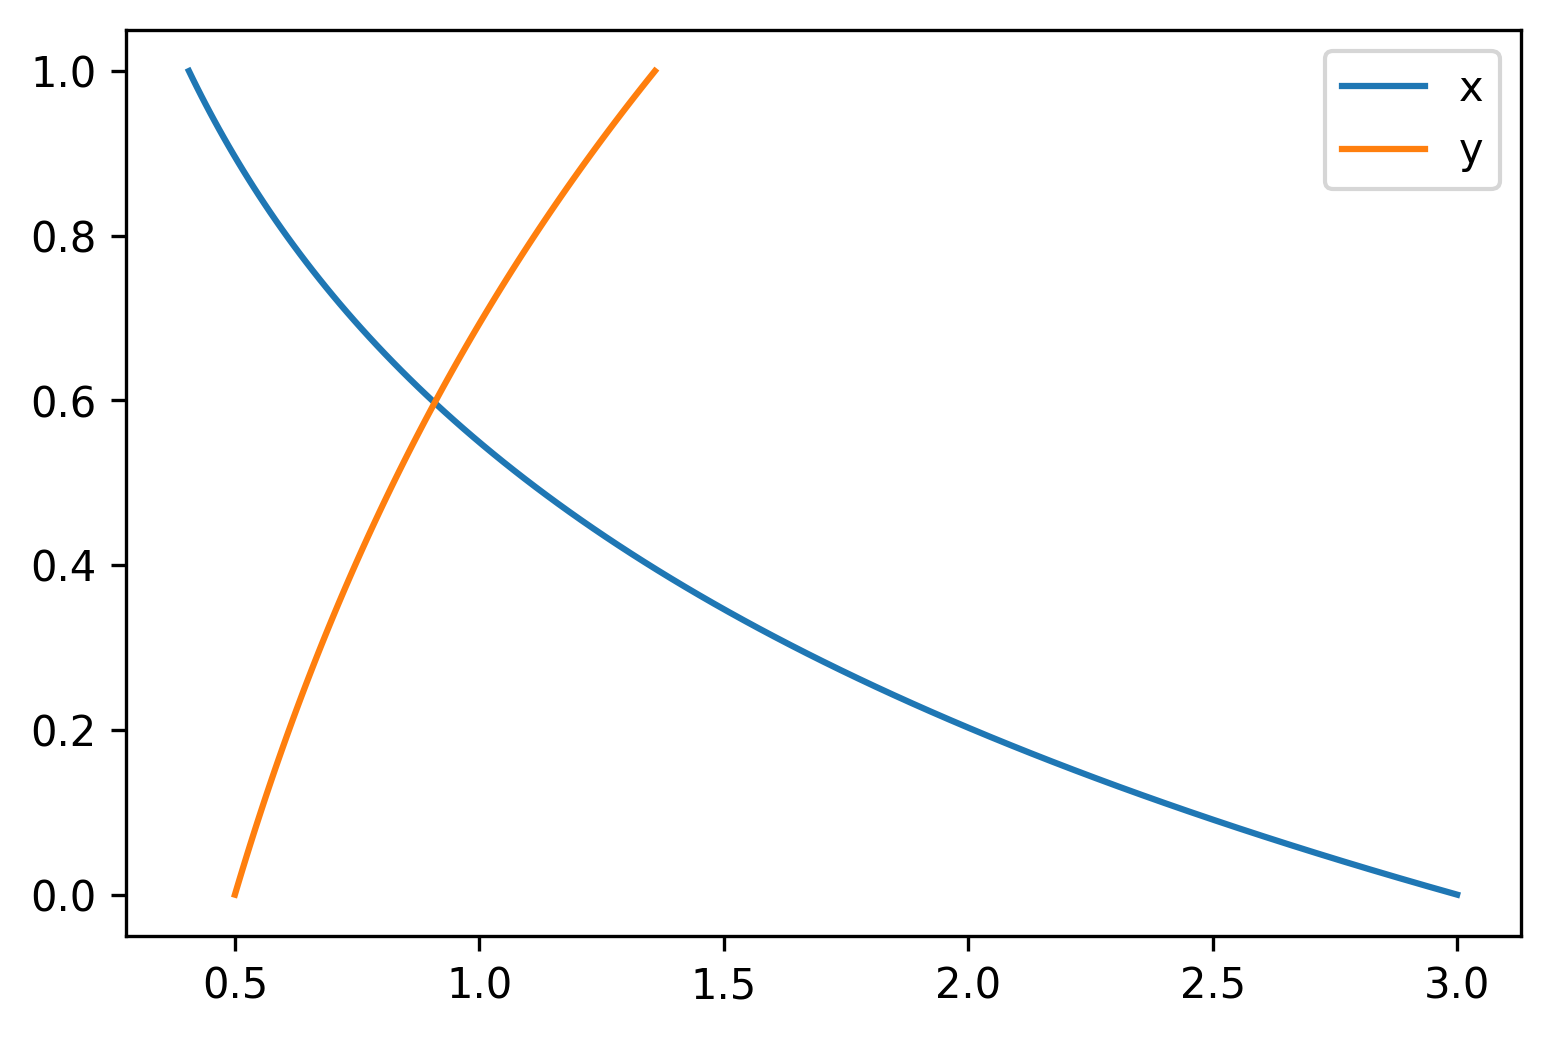

In [ ]:
plt.figure(dpi=300)
plt.plot(X[:, 0], t, label="x") # x, t
plt.plot(X[:, 1], t, label="y") # y, t
plt.legend()

We can select a differentiation method from the `differentiation` submodule.

In [ ]:
differentiation_method = ps.FiniteDifference(order=2)

While we could use this method to compute $\dot X$ "by hand," it is often more convenient to pass it into the `SINDy` object and let the computation of $\dot X$ be handled automatically.

The candidate library can be specified with an object from the `feature_library` submodule, which will also be passed into the `SINDy` object.

In [ ]:
feature_library = ps.PolynomialLibrary(degree=3)

Next we select which optimizer should be used.

In [ ]:
optimizer = ps.STLSQ(threshold=0.2)

Finally, we bring these three components together in one `SINDy` object.

In [ ]:
model_X = ps.SINDy(
    differentiation_method=differentiation_method, #Finite difference (order=2)
    feature_library=feature_library, #Polynomial library, degree=3
    optimizer=optimizer, #STLSQ (threshold=0.2)
    feature_names=["x", "y"]
)

model_X_noise = copy.deepcopy(model_X) # needed to have multiple models

Following the `scikit-learn` workflow, we first instantiate a `SINDy` class object with the desired properties, then fit it to the data in separate step.

In [ ]:
model_X = model_X.fit(X, t=t)

We can inspect the governing equations discovered by the model and check whether they seem reasonable with the `print` function.

In [ ]:
model_X.print(lhs=['dx_dt', 'dy_dt'])

dx_dt = -2.000 x
dy_dt = 1.000 y


In [ ]:
feature_library = ps.PolynomialLibrary(degree=3, interaction_only=True)

In [ ]:
model_X_noise = ps.SINDy(
    differentiation_method=differentiation_method, #Finite difference (order=2)
    feature_library=feature_library, #Polynomial library, degree=3
    optimizer=optimizer, #STLSQ (threshold=0.2)
    feature_names=["x", "y"]
)

$\frac{dx}{dt} = -2x$
$\frac{dy}{dt} = y$

In [ ]:
functions = [lambda x: x, lambda y: y]
feature_library = ps.CustomLibrary(library_functions=functions)

In [ ]:
model_X_noise = ps.SINDy(
    differentiation_method=differentiation_method, #Finite difference (order=2)
    feature_library=feature_library, #Custom library
    optimizer=optimizer, #STLSQ (threshold=0.2)
    feature_names=["x", "y"]
)

library_functions (list of mathematical functions) – Functions to include in the library. Default is to use same functions for all variables. Can also be used so that each variable has an associated library, in this case library_functions is shape (n_input_features, num_library_functions)

In [ ]:
# functions = ([lambda x: x, lambda x,y: y])
functions_x = [lambda x: x]
functions_y = [lambda y: y]

feature_library_x = ps.CustomLibrary(library_functions=functions_x)
feature_library_y = ps.CustomLibrary(library_functions=functions_y)

In [ ]:
feature_libraries = feature_library_x + feature_library_y

In [ ]:
model_X_noise = ps.SINDy(
    differentiation_method=differentiation_method, #Finite difference (order=2)
    feature_library=feature_libraries, #Custom library
    optimizer=optimizer, #STLSQ (threshold=0.2)
    feature_names=["x", "y"]
)

In [ ]:
data_generator = dataGen(x=3*np.exp(-2*t), y=0.5*np.exp(t))
X_noise = data_generator.generate_data(noise_scale=0.01)

In [ ]:
model_X_noise = model_X_noise.fit(X_noise, t=t)
model_X_noise.print(lhs=['dx_dt', 'dy_dt'])

dx_dt = -0.984 f0(x) + -0.984 f0(x)
dy_dt = 0.494 f0(y) + 0.494 f0(y)


In [ ]:
model_X_noise.get_feature_names()

['f0(x)', 'f0(y)', 'f0(x)', 'f0(y)']

## Enforcing specific terms to fit, and applying those terms only to specific input variables

In [ ]:
functions_x = [lambda x: x]
functions_y = [lambda y: y]

functions_names_x = [lambda x: ' ' + x]
functions_names_y = [lambda y: ' ' + y]

feature_library_x = ps.CustomLibrary(library_functions=functions_x, function_names = functions_names_x)
feature_library_y = ps.CustomLibrary(library_functions=functions_y, function_names = functions_names_y)


In [ ]:
# Remove X and Y from their respective library terms

# Initialize the default inputs, i.e. each library
# uses all the input variables, (2 inputs and 2 libraries here)
inputs_temp = np.tile([0, 1], 2)
inputs_per_library = np.reshape(inputs_temp, (2, 2))
print(inputs_per_library)
# # functions_x ([0, 1] inputs x [0]
inputs_per_library[0, 0] = 0 #(library 1 [0, ](functions_x), y [, 1] is removed)
inputs_per_library[0, 1] = 0 #(library 1 [0, ](functions_x), y [, 1] is removed)

# # functions_y (1, 0] inputs y [1]
inputs_per_library[1, 0] = 1 #(library 2 [1, ](functions_y), x [, 0] is removed)
inputs_per_library[1, 1] = 1 #(library 2 [1, ](functions_y), x [, 0] is removed)

#x = 0
#y = 1
#z = 2
#u_0 = 3
#u_1 = 4

# # Don't use the x, u0, u1 inputs for generating the Fourier library
# inputs_per_library[1, 2] = 1
# inputs_per_library[1, 3] = 1
# inputs_per_library[1, 4] = 1

# # Don't use the y, z, u0 inputs for generating the custom library
# inputs_per_library[2, 1] = 0
# inputs_per_library[2, 2] = 0
# inputs_per_library[2, 3] = 0
print(inputs_per_library)


[[0 1]
 [0 1]]
[[0 0]
 [1 1]]


In [ ]:
X_noise = data_generator.generate_data(noise_scale=0.01)

In [ ]:
feature_names = ['x','y']
generalized_library = ps.GeneralizedLibrary(
    [feature_library_x, feature_library_y],
    inputs_per_library=inputs_per_library,
)

optimizer = ps.STLSQ(threshold=8,alpha=1e-3, normalize_columns=True)
model = ps.SINDy(feature_library=generalized_library,
                 optimizer=optimizer,
                 feature_names=feature_names)
model.fit(X_noise, t=t)
model.get_feature_names()
model.print(lhs=['dx/dt','dy/dt'], precision=2)

dx/dt = -1.99  x
dy/dt = 1.04  y


In [ ]:

def plot_sim(x0, y0, t_test, x_test, y_test, sim):
  plt.figure(dpi=200)
  plt.plot(x0, y0, "ro", label="Initial condition", alpha=0.6, markersize=8)
  plt.plot(x_test, y_test, "b", label="Exact solution", alpha=0.4, linewidth=4)
  plt.plot(sim[:, 0], sim[:, 1], "k--", label="SINDy model", linewidth=3)
  plt.xlabel("x")
  plt.ylabel("y")
  plt.legend()
  plt.show()



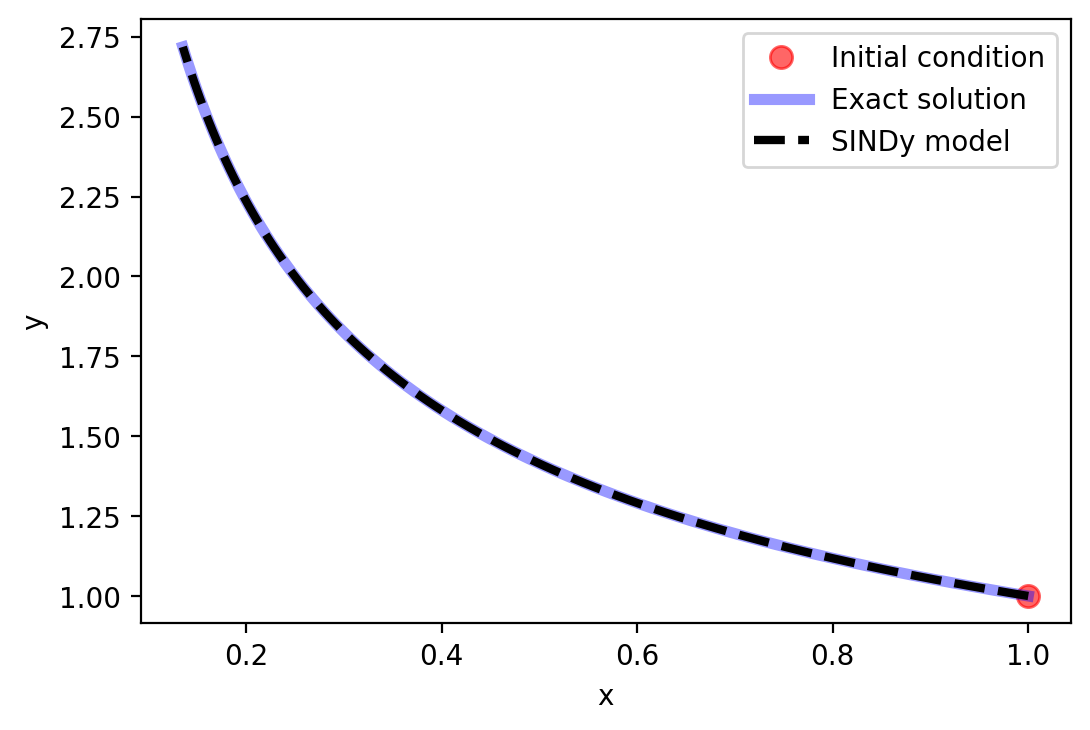

In [ ]:
x0 = 1
y0 = 1

t_test = np.linspace(0, 1, 100)
x_test = x0 * np.exp(-2 * t_test)
y_test = y0 * np.exp(t_test)

sim = model_X.simulate([x0, y0], t=t_test)
plot_sim(x0, y0, t_test, x_test, y_test, sim)

Once the SINDy model has been fit we can use it to evolve new initial conditions forward in time with the `simulate` function.

In [ ]:
x0 = 6
y0 = -0.1

t_test = np.linspace(0, 1, 100)
x_test = x0 * np.exp(-2 * t_test)
y_test = y0 * np.exp(t_test)

sim = model_X.simulate([x0, y0], t=t_test)

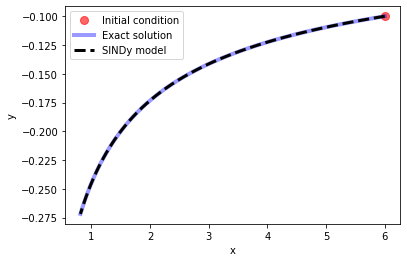

In [ ]:
plot_sim(x0, y0, t_test, x_test, y_test, sim)

In [ ]:
sim_noisy = model_X_noise.simulate([x0, y0], t=t_test)

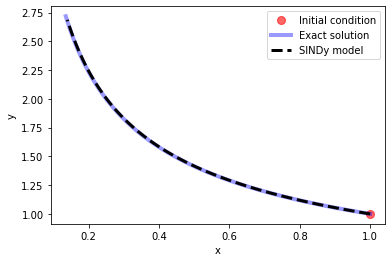

In [ ]:
plot_sim(x0, y0, t_test, x_test, y_test, sim_noisy)

dx_dt = -2.430  x + 0.876  y
dy_dt = -3.281  x + 9.175  y


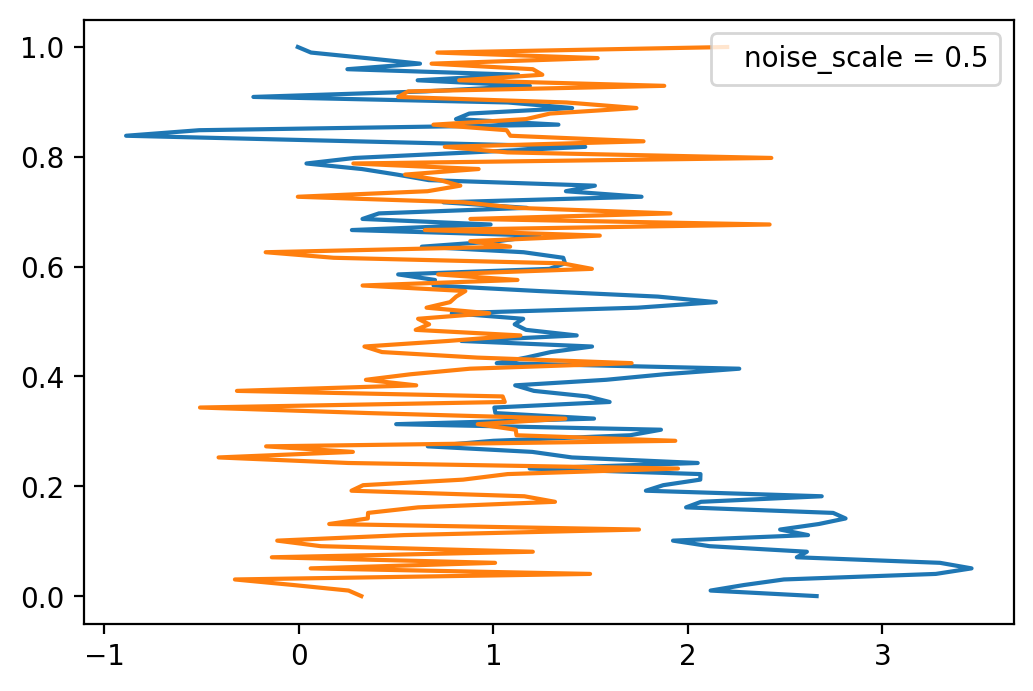

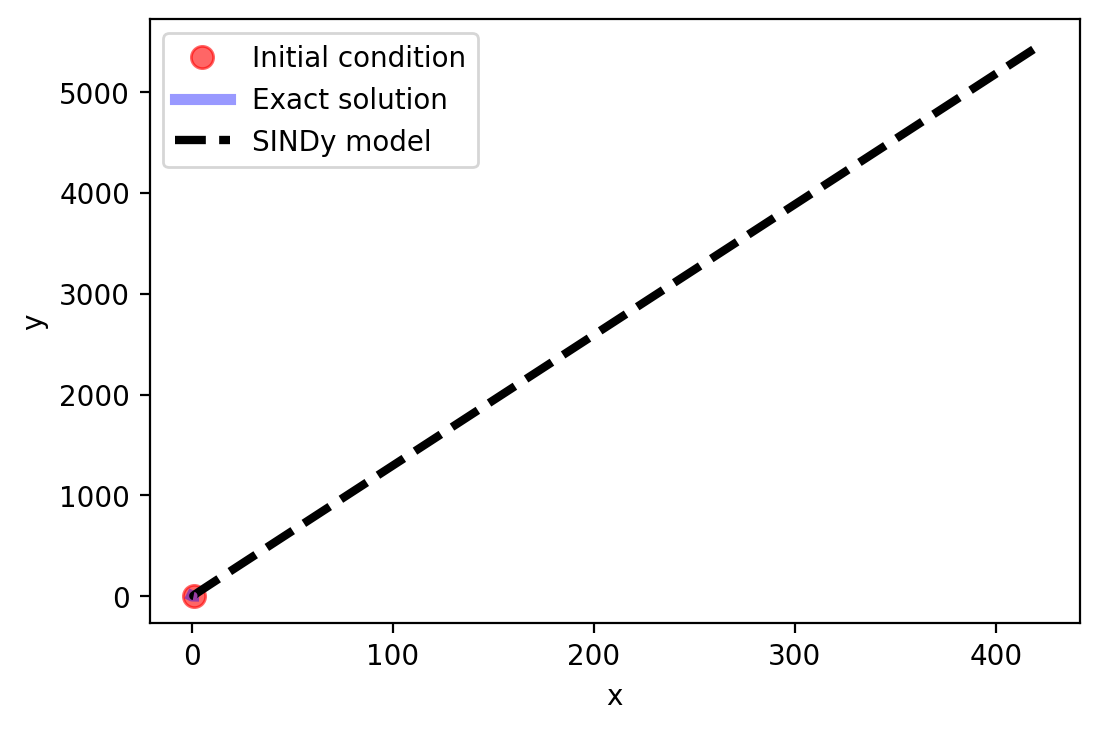

dx_dt = -3.777  x + 2.330  y
dy_dt = 0.710  x


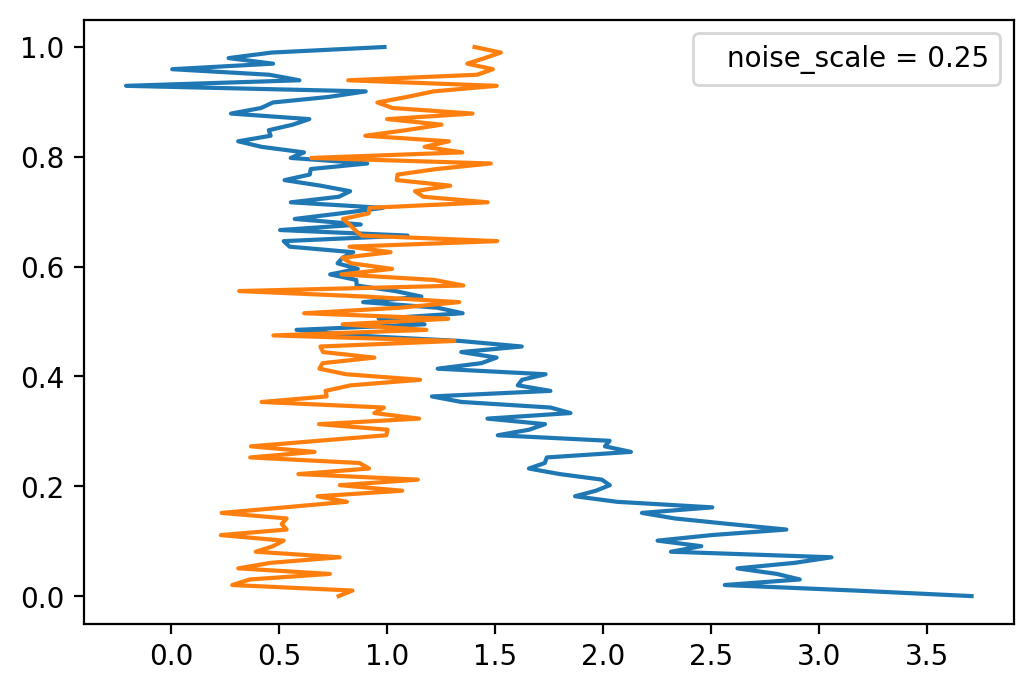

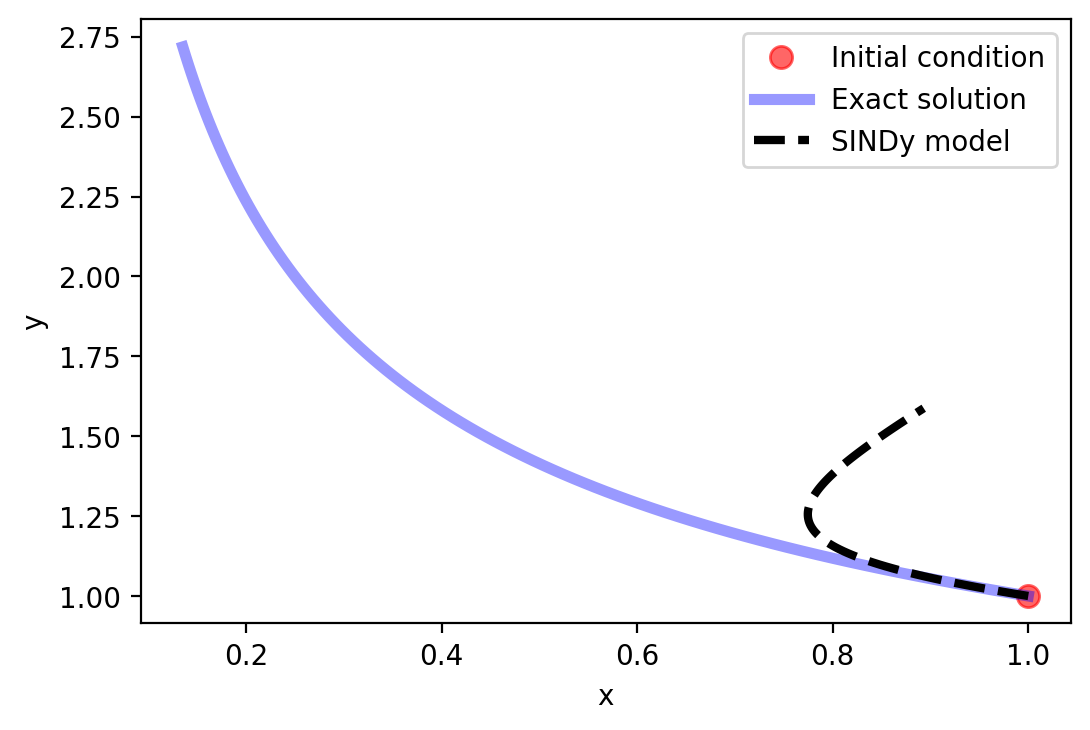

dx_dt = -2.309  x + 1.040  y
dy_dt = -1.129  x + 2.004  y


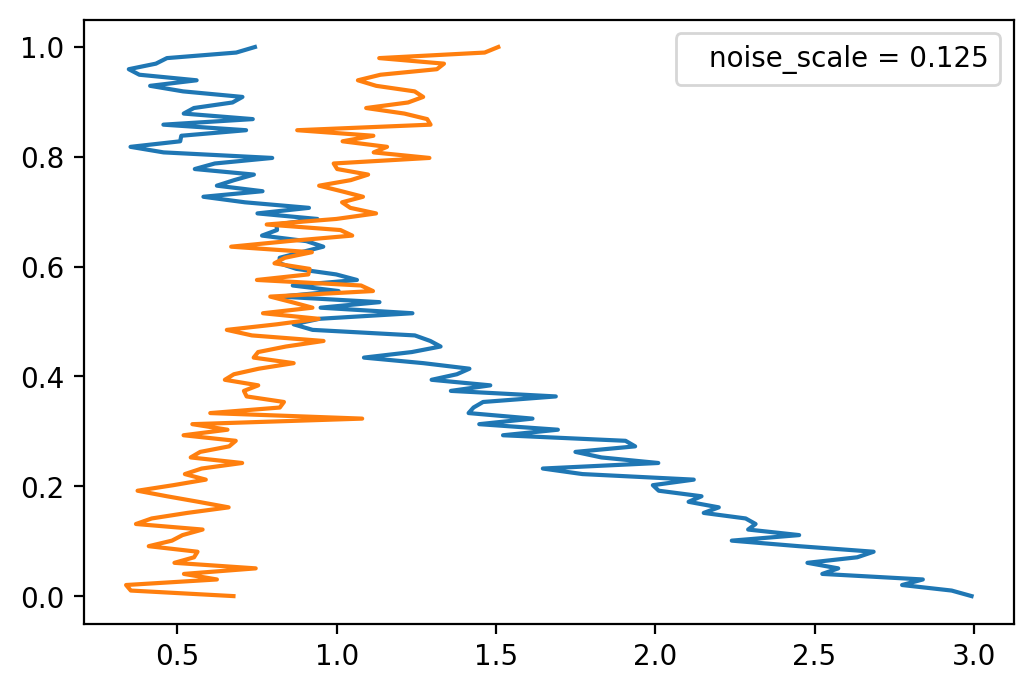

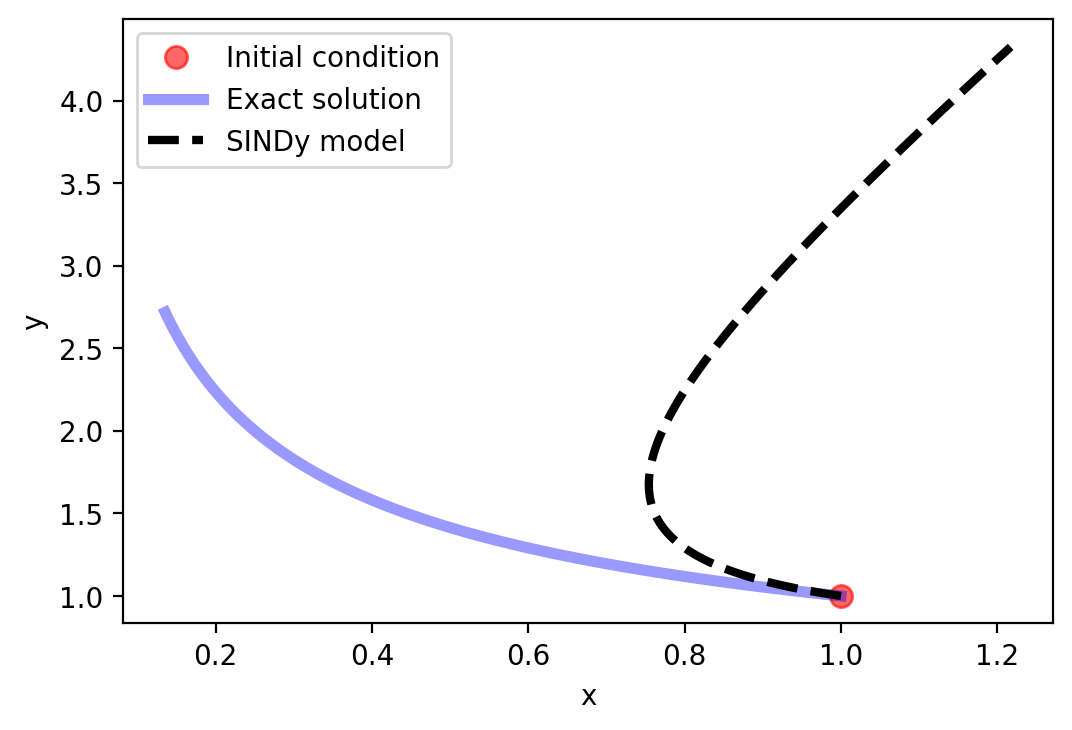

dx_dt = -2.237  x
dy_dt = 0.000


/usr/local/lib/python3.9/dist-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (8) and eliminated all coefficients
  warnings.warn(


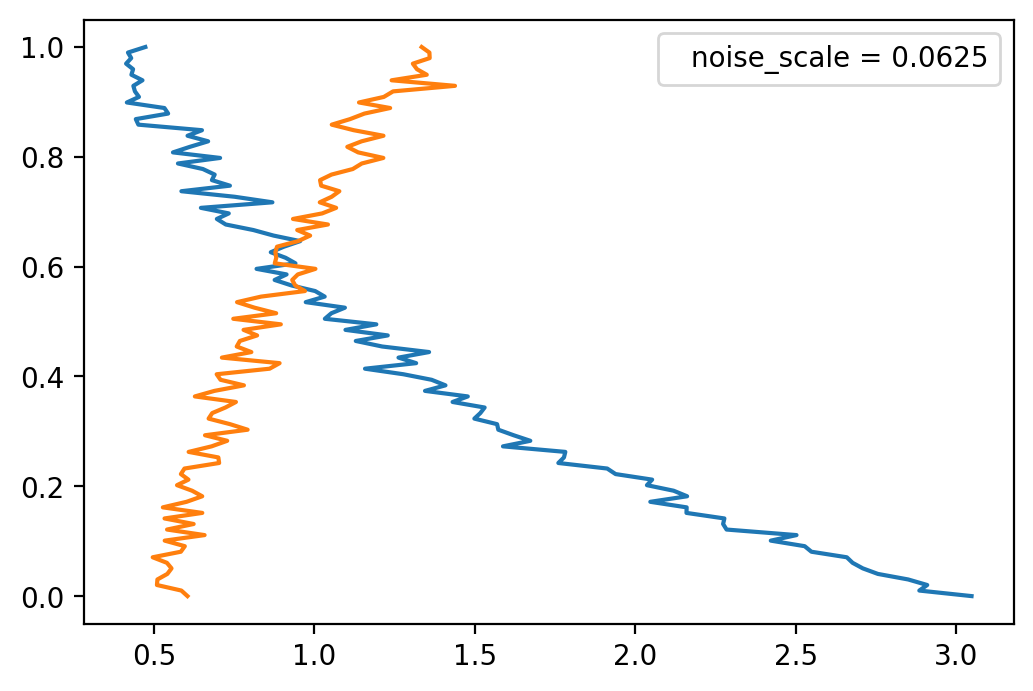

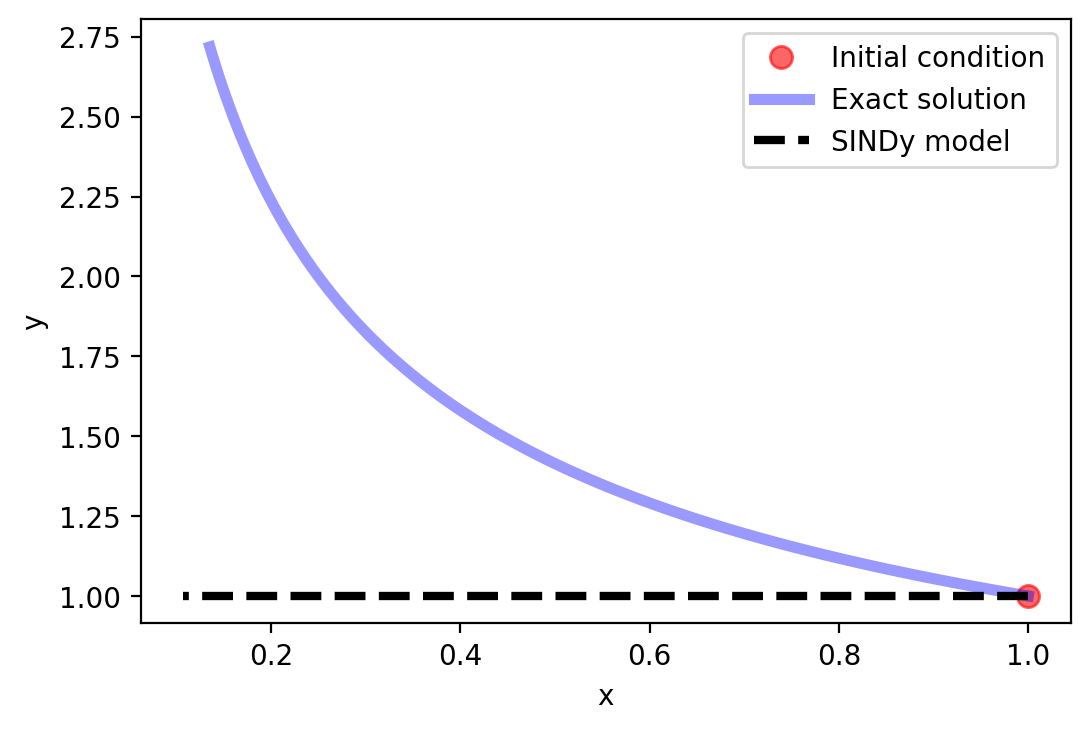

dx_dt = -1.988  x
dy_dt = 1.238  y


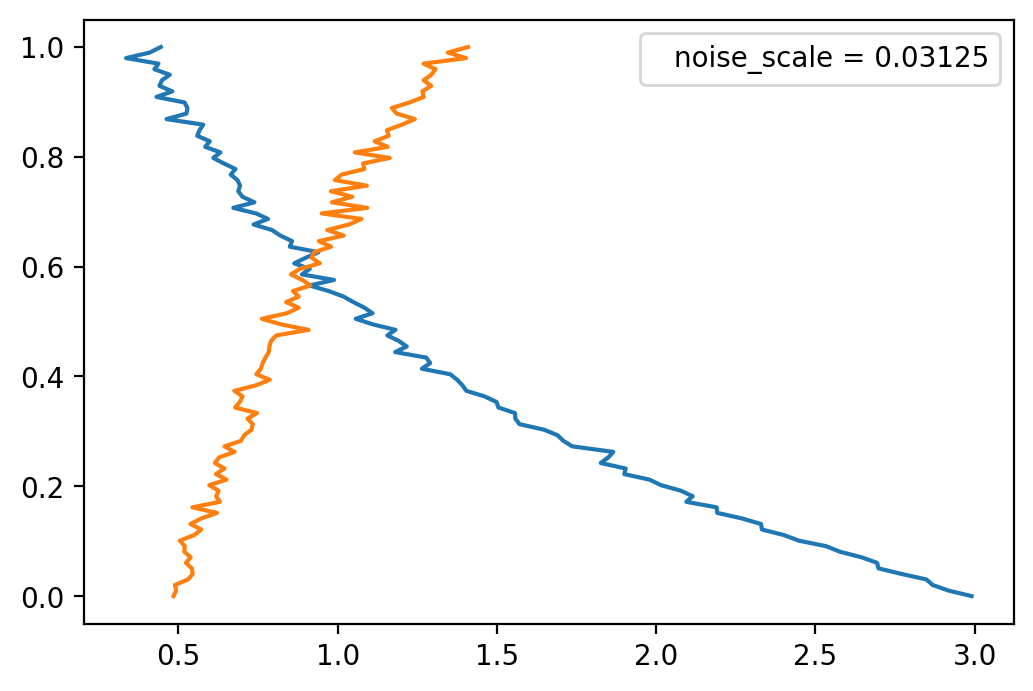

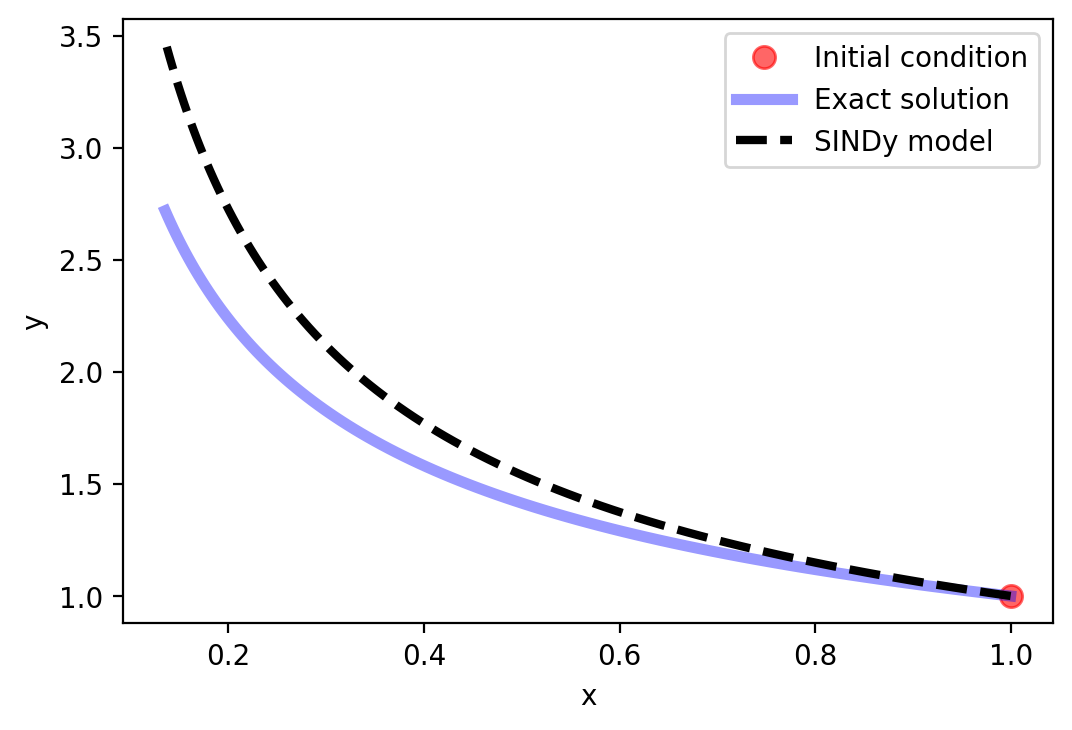

dx_dt = -1.932  x
dy_dt = 1.092  y


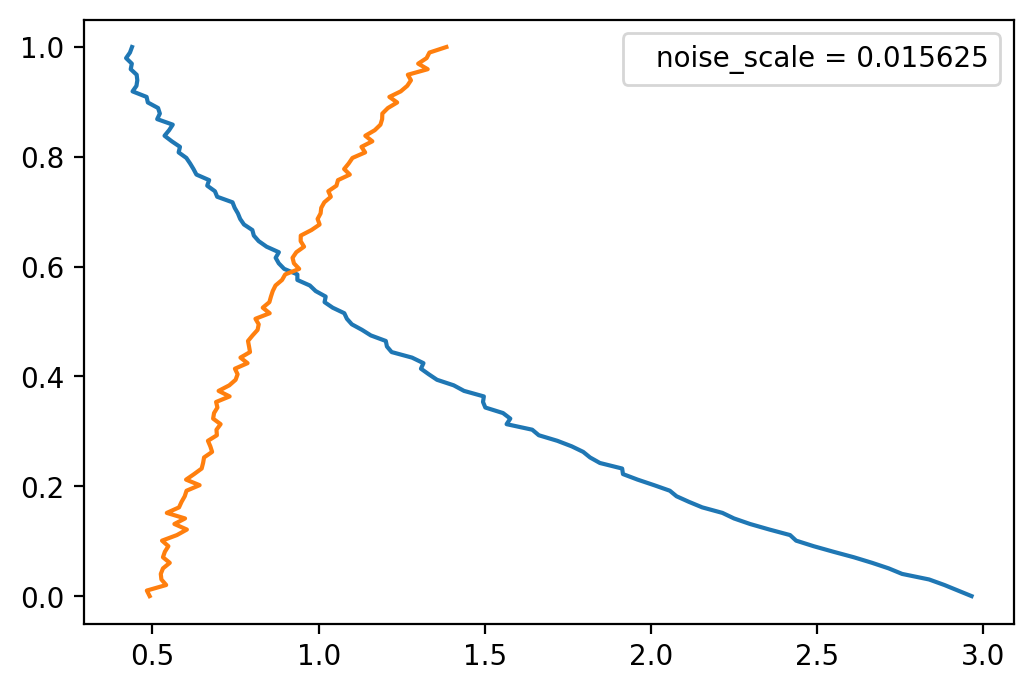

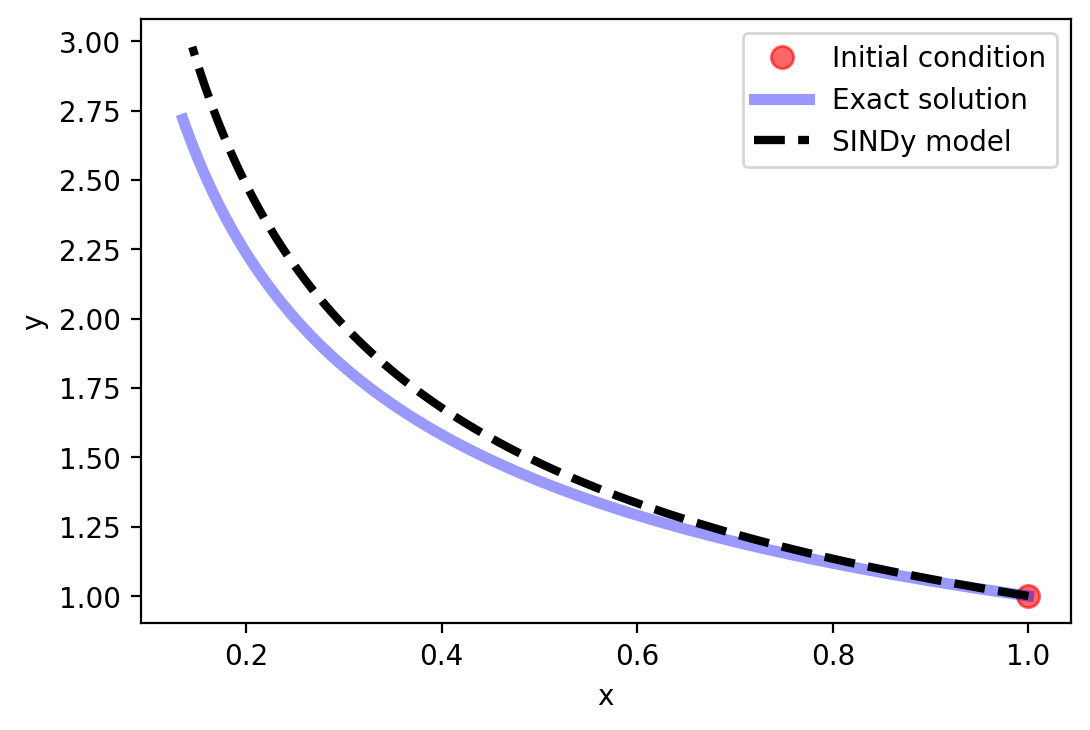

dx_dt = -1.969  x
dy_dt = 1.019  y


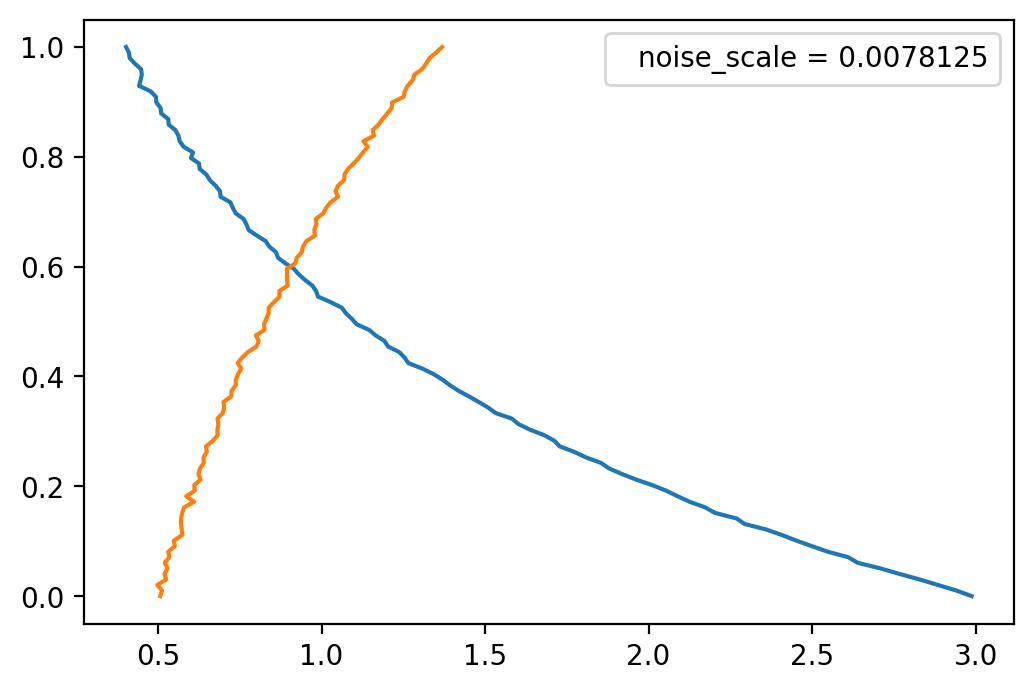

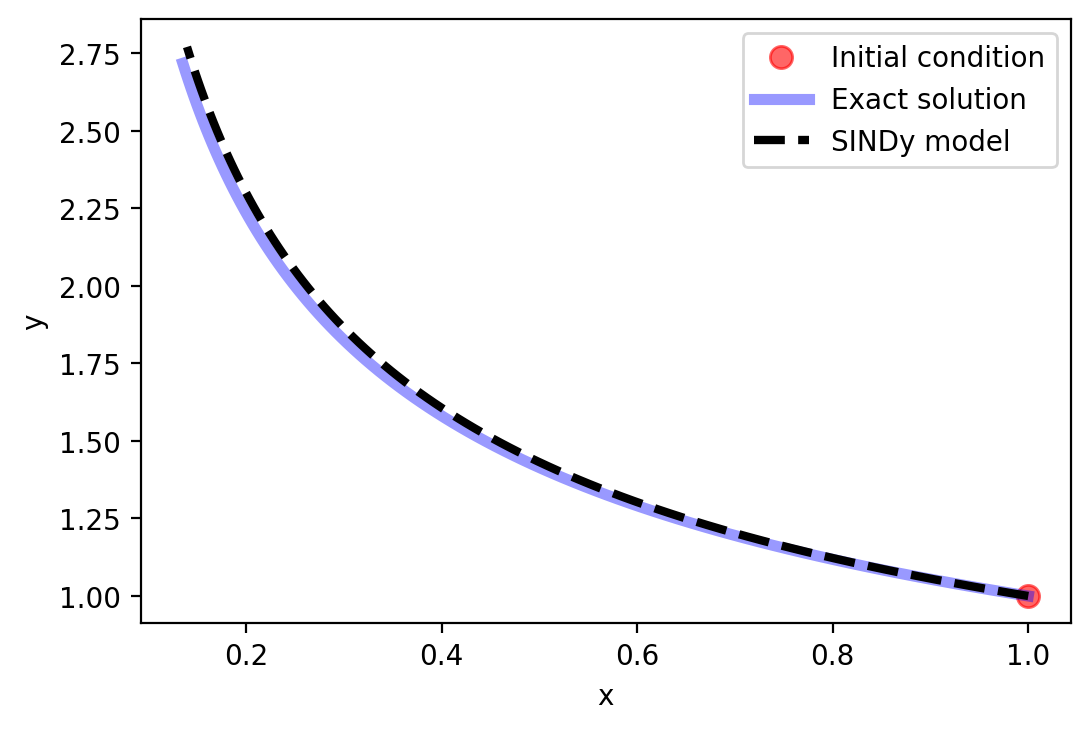

dx_dt = -2.028  x
dy_dt = 1.002  y


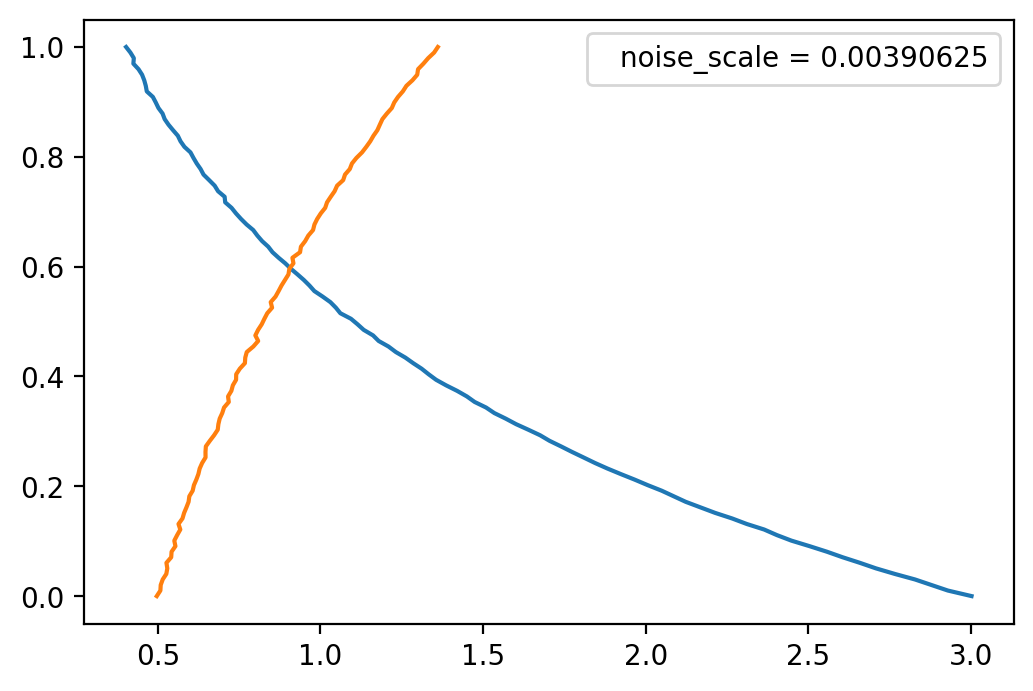

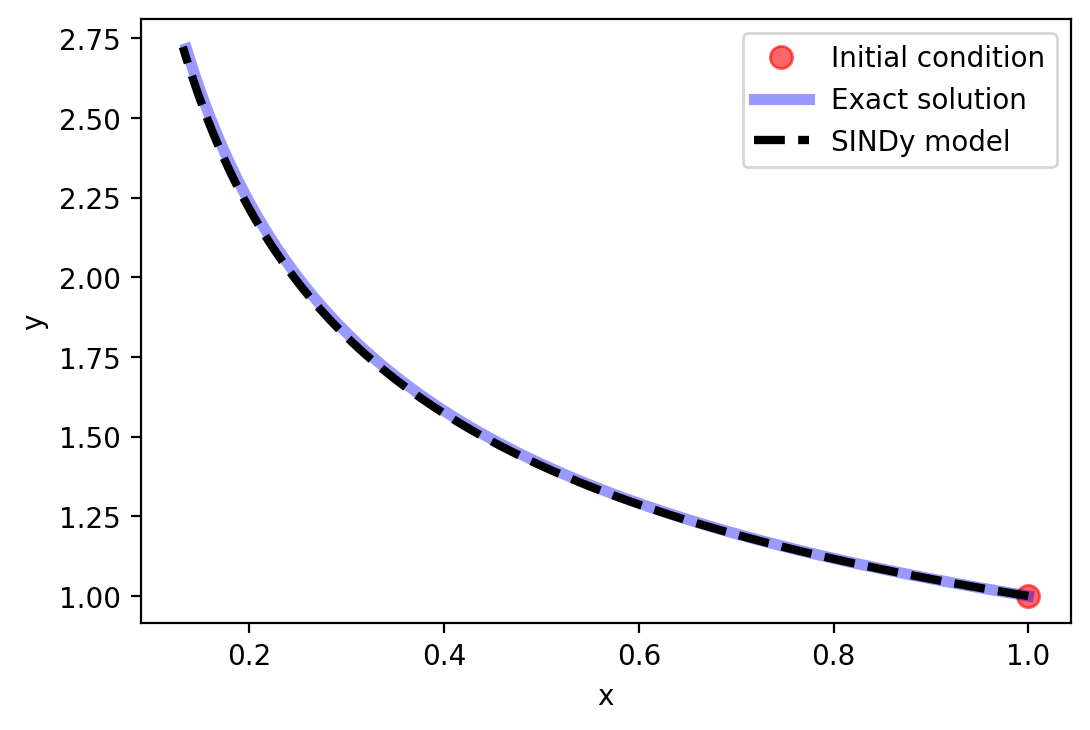

dx_dt = -2.006  x
dy_dt = 0.991  y


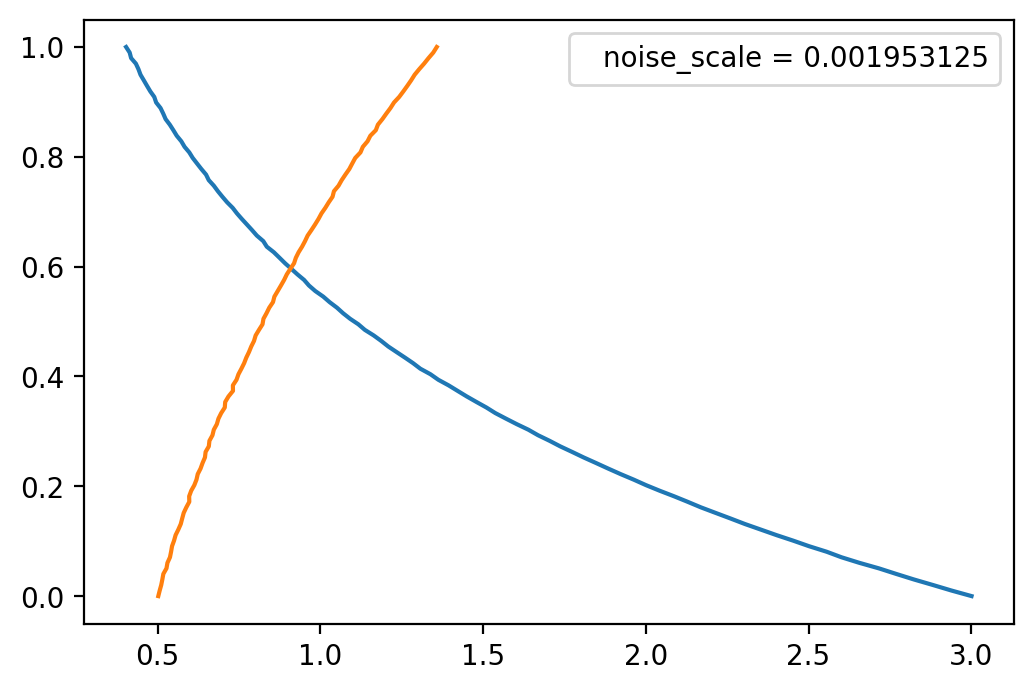

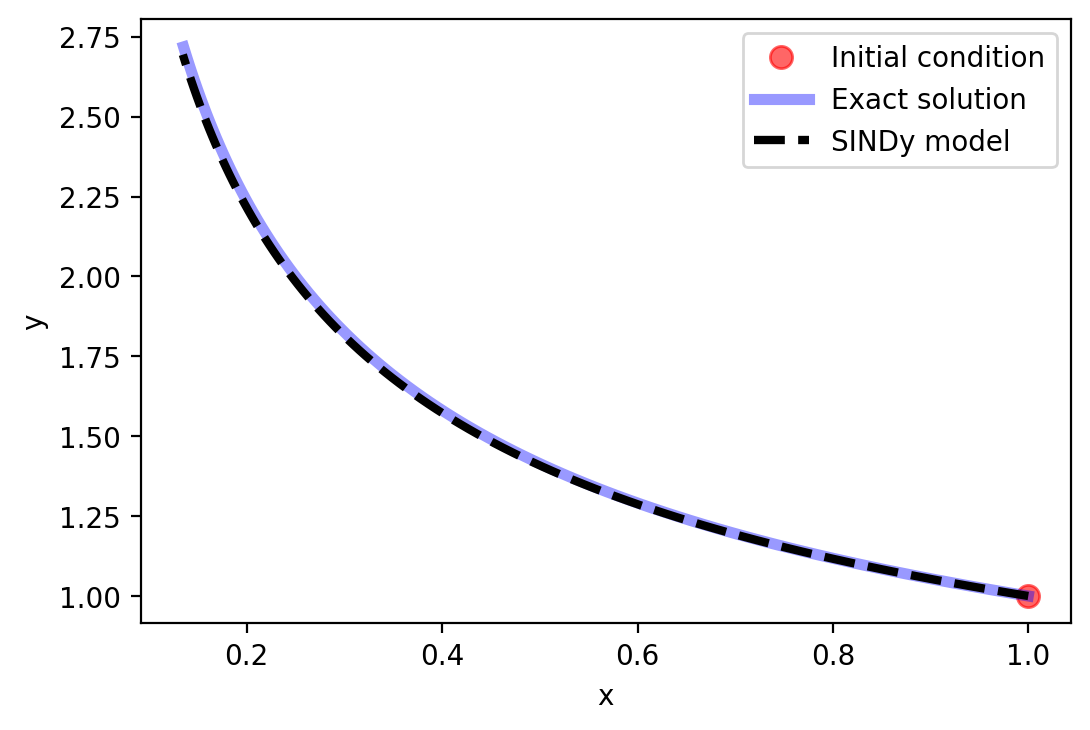

dx_dt = -1.996  x
dy_dt = 1.002  y


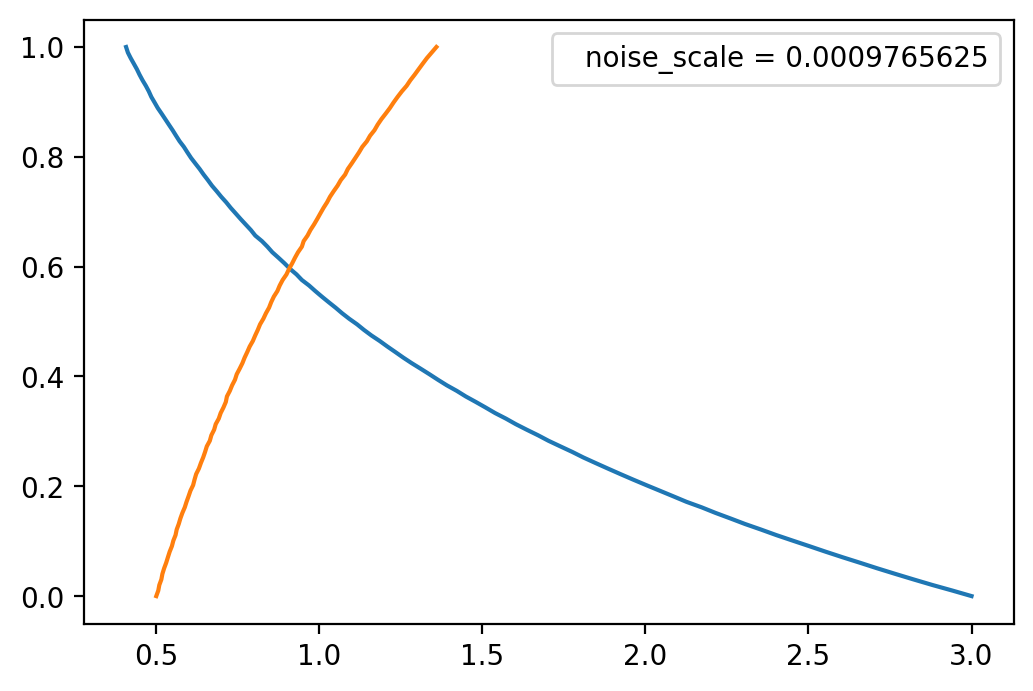

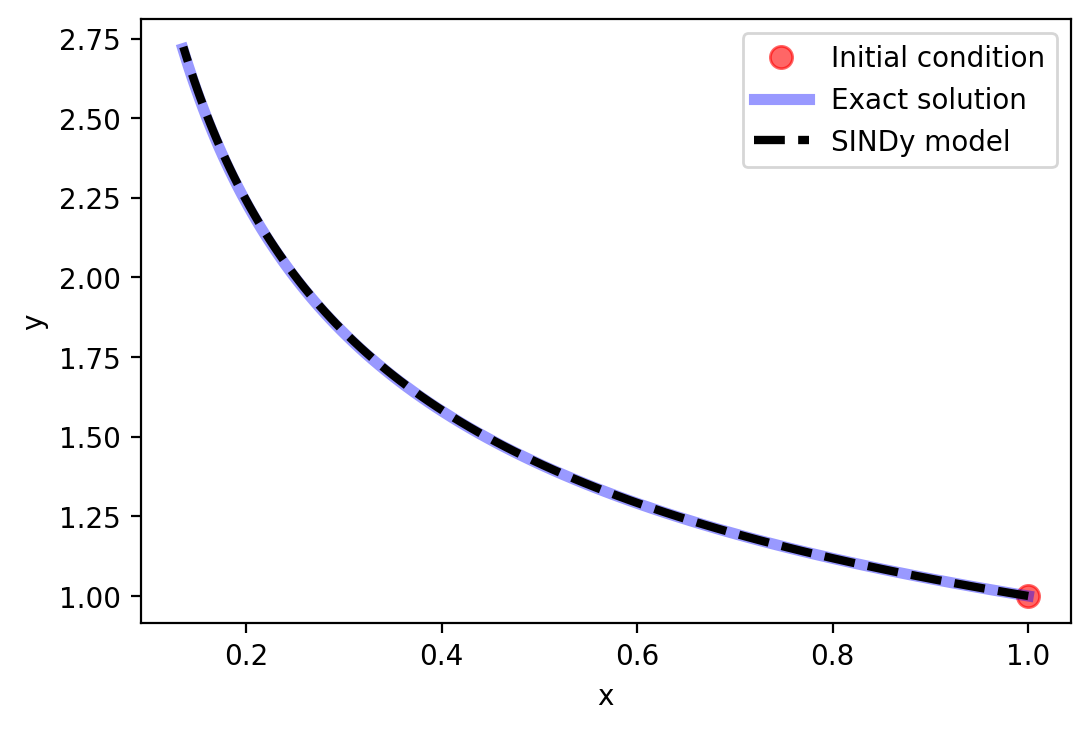

In [ ]:
data_generator_noise = dataGen(x = 3*np.exp(-2*t), y=0.5*np.exp(t))
noise_scale = 0.5
model_X = ps.SINDy(
    differentiation_method=differentiation_method, #Finite difference (order=2)
    feature_library=feature_library, #Polynomial library, degree=3
    optimizer=optimizer, #STLSQ (threshold=0.2)
    feature_names=["x", "y"]
)

for i in range(0, 10):

  model_X_noise_i = copy.deepcopy(model)
  X_noise_i = data_generator.generate_data(noise_scale=noise_scale)
  locals()[f'X_noise_{i}'] = X_noise_i # iteratively assign variable names

  plt.figure(dpi=200)
  plt.plot(X_noise_i[:,0], t, label=f'noise_scale = {noise_scale}')
  plt.plot(X_noise_i[:,1], t)
  plt.legend(handlelength=0, loc='upper right')

  noise_scale = noise_scale/2
  model_X_noise_i.fit(X_noise_i, t=t)
  model_X_noise_i.print(lhs=['dx_dt', 'dy_dt'])
  plt.show()

  sim_noisy = model_X_noise_i.simulate([x0, y0], t=t_test)
  plot_sim(x0, y0, t_test, x_test, y_test, sim_noisy)

\begin{aligned}
\frac{dx}{dt} = -1.996x \
\frac{dy}{dt} = 1.002y \
\end{aligned}

\begin{aligned}
\frac{dx}{dt} = -1.969x \
\frac{dy}{dt} = 1.019y \
\end{aligned}

\begin{aligned}
\frac{dx}{dt} = -1.988x \
\frac{dy}{dt} = 1.238y \
\end{aligned}

\begin{aligned}
\frac{dx}{dt} = -2.237x \
\frac{dy}{dt} = 0.000y \
\end{aligned}

### **Important caveat:**

Note that if the library we had chosen had been inappropriate for the problem at hand (i.e. if the dynamics could not be well-approximated as a sparse linear combination of library functions), then SINDy would have failed to produce a reasonable model. For example, if we solve the same problem, but using sines and cosines as our basis functions, SINDy is unable to find a sparse model for the dynamics:

In [ ]:
# Populate the library with trigonometric functions
feature_library = ps.FourierLibrary()

model = ps.SINDy(
    differentiation_method=differentiation_method,
    feature_library=feature_library,
    optimizer=optimizer,
    feature_names=["x", "y"]
)
model.fit(X, t=t)
model.print()

(x)' = 0.772 sin(1 x) + 2.097 cos(1 x) + -2.298 sin(1 y) + -3.115 cos(1 y)
(y)' = 1.362 sin(1 y) + -0.222 cos(1 y)


$\frac{dx}{dt} = 0.772 \sin(x) + 2.097 \cos(x) + -2.298 \sin(y) + -3.115 \cos(y)$
\
\
$\frac{dy}{dt} = 1.362 \sin(y) + -0.222 cos(y)$

In [ ]:
x0 = 6
y0 = -0.1

t_test = np.linspace(0, 1, 100)
x_test = x0 * np.exp(-2 * t_test)
y_test = y0 * np.exp(t_test)

sim = model.simulate([x0, y0], t=t_test)

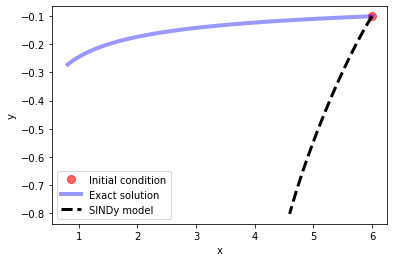

In [ ]:
plt.figure()
plt.plot(x0, y0, "ro", label="Initial condition", alpha=0.6, markersize=8)
plt.plot(x_test, y_test, "b", label="Exact solution", alpha=0.4, linewidth=4)
plt.plot(sim[:, 0], sim[:, 1], "k--", label="SINDy model", linewidth=3)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

# 2: PDEFIND on two component coupled reaction diffusion PDEs.

These PDEs exhibit spiral waves on a periodic domain and are defined as:

\begin{align}
\frac{\partial u}{\partial t} &= 0.1 \nabla^2 u + (1-A^2)u + \beta A^2 v \\
\frac{\partial v}{\partial t} &= 0.1 \nabla^2 v + \beta A^2 u + (1-A^2)v
\end{align}

Where $A^2 = u^2 + v^2$.

$$\frac{\partial u}{\partial t} = u - u^3 - uv^2 + \beta u^2v + \beta v^3$$

$$\frac{\partial v}{\partial t} = v - u^2v - v^3 - \beta u^3 - \beta uv^2$$


Compared to computing terms of simpler PDEs e.g. Burger's equation, this will require a larger library of candidate terms. These will be:


*   Cubic terms in (u, v)
*   The first and second order derivatives of these terms.



## First we define the reaction-diffusion PDEs in the Fourier (kx, ky) space.

In [ ]:
def reaction_diffusion(t, uvt, K22, d1, d2, beta, n, N):
    ut = np.reshape(uvt[:N], (n, n))
    vt = np.reshape(uvt[N : 2 * N], (n, n))
    u = np.real(ifft2(ut))
    v = np.real(ifft2(vt))
    u3 = u ** 3
    v3 = v ** 3
    u2v = (u ** 2) * v
    uv2 = u * (v ** 2)


    # just change these lines
    utrhs = np.reshape((fft2(u - u3 - uv2 + beta * u2v + beta * v3)), (N, 1))
    vtrhs = np.reshape((fft2(v - u2v - v3 - beta * u3 - beta * uv2)), (N, 1))


    uvt_reshaped = np.reshape(uvt, (len(uvt), 1))
    uvt_updated = np.squeeze(
        np.vstack(
            (-d1 * K22 * uvt_reshaped[:N] + utrhs,
             -d2 * K22 * uvt_reshaped[N:] + vtrhs)
        )
    )
    return uvt_updated

## We then generate some data to fit to.

In [ ]:
t = np.linspace(0, 10, int(10 / 0.05))
d1 = 0.1
d2 = 0.1
beta = 1.0
L = 20  # Domain size in X and Y directions
n = 128  # Number of spatial points in each direction
N = n * n
x_uniform = np.linspace(-L / 2, L / 2, n + 1)
x = x_uniform[:n]
y = x_uniform[:n]
n2 = int(n / 2)

# Define Fourier wavevectors (kx, ky)
kx = (2 * np.pi / L) * np.hstack((np.linspace(0, n2 - 1, n2),
                                  np.linspace(-n2, -1, n2)))
ky = kx

# Get 2D meshes in (x, y) and (kx, ky)
X, Y = np.meshgrid(x, y)
KX, KY = np.meshgrid(kx, ky)
K2 = KX ** 2 + KY ** 2
K22 = np.reshape(K2, (N, 1))
m = 1  # number of spirals

# define our solution vectors
u = np.zeros((len(x), len(y), len(t)))
v = np.zeros((len(x), len(y), len(t)))

## Initial conditions

In [ ]:
# Initial conditions
u[:, :, 0] = np.tanh(np.sqrt(X ** 2 + Y ** 2)) * np.cos(
    m * np.angle(X + 1j * Y) - (np.sqrt(X ** 2 + Y ** 2))
)
v[:, :, 0] = np.tanh(np.sqrt(X ** 2 + Y ** 2)) * np.sin(
    m * np.angle(X + 1j * Y) - (np.sqrt(X ** 2 + Y ** 2))
)

# uvt is the solution vector in Fourier space, so below
# we are initializing the 2D FFT of the initial condition, uvt0
uvt0 = np.squeeze(
    np.hstack(
        (np.reshape(fft2(u[:, :, 0]), (1, N)),
         np.reshape(fft2(v[:, :, 0]), (1, N)))
    )
)

## Solve the spiral PDEs

In [ ]:
# Solve the PDE in the Fourier space, where it reduces to system of ODEs
uvsol = solve_ivp(
    reaction_diffusion, (t[0], t[-1]), y0=uvt0, t_eval=t,
    args=(K22, d1, d2, beta, n, N), **integrator_keywords
)
uvsol = uvsol.y

In [ ]:
## Reshape things and ifft back into (x, y, t) space from (kx, ky, t) space
for j in range(len(t)):
    ut = np.reshape(uvsol[:N, j], (n, n))
    vt = np.reshape(uvsol[N:, j], (n, n))
    u[:, :, j] = np.real(ifft2(ut))
    v[:, :, j] = np.real(ifft2(vt))

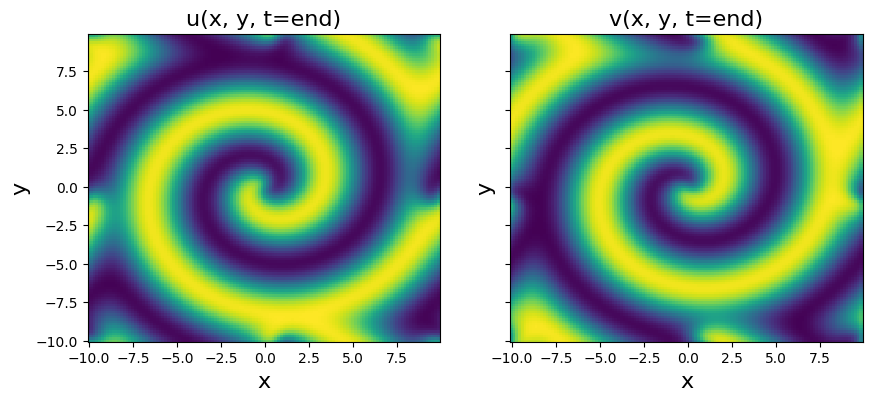

In [ ]:
# Plot to check if spiral is nicely reproduced
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.pcolor(X, Y, u[:, :, -1])
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.title('u(x, y, t=end)', fontsize=16)
plt.subplot(1, 2, 2)
plt.pcolor(X, Y, v[:, :, -1])
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title('v(x, y, t=end)', fontsize=16)

dt = t[1] - t[0]
dx = x[1] - x[0]
dy = y[1] - y[0]

u_sol = u
v_sol = v

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
path = '/content/drive/MyDrive/Python_projects/EQL_Schnakenberg/'
os.chdir(path)

In [ ]:
print(u_sol.shape)

# Compute u_t from generated solution
u = np.zeros((n, n, len(t), 2))
u[:, :, :, 0] = u_sol
u[:, :, :, 1] = v_sol

print(u.shape)

# uncomment to save the solution to file

array_save_path = os.path.join(path + 'solution.pkl')
u = save_solution(array_save_path, '2D_Reaction_diffusion_example_soln', u)
print(u.shape)

(128, 128, 200)
(128, 128, 200, 2)
(128, 128, 200, 2)


In [ ]:
dt = t[1] - t[0]
u_dot = ps.FiniteDifference(axis=2)._differentiate(u, dt)

## The actual training

In [ ]:
# Choose 60 % of data for training because data is big...
# can only randomly subsample if you are passing u_dot to model.fit!!!
train = np.random.choice(len(t), int(len(t) * 0.6), replace=False)
test = [i for i in np.arange(len(t)) if i not in train]
u_train = u[:, :, train, :]
u_test = u[:, :, test, :]
u_dot_train = u_dot[:, :, train, :]
u_dot_test = u_dot[:, :, test, :]
t_train = t[train]
t_test = t[test]
spatial_grid = np.asarray([X, Y]).T

### Construct the library functions and model

In [ ]:
# polynomial library of order 3 (default?)
# Odd polynomial terms in (u, v), up to second order derivatives in (u, v)
library_functions = [
    lambda x: x,
    lambda x: x * x * x,
    lambda x, y: x * y * y,
    lambda x, y: x * x * y,
]
library_function_names = [
    lambda x: x,
    lambda x: x + x + x,
    lambda x, y: x + y + y,
    lambda x, y: x + x + y,
]
pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=2,
    spatial_grid=spatial_grid,
    include_bias=True,
    is_uniform=True,
    periodic=True
)
print('STLSQ model: ')
optimizer = ps.STLSQ(threshold=50, alpha=1e-5,
                     normalize_columns=True, max_iter=200)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u_train, x_dot=u_dot_train)
model.print()
u_dot_stlsq = model.predict(u_test)



STLSQ model: 
(x0)' = 1.020 x0 + -1.020 x0x0x0 + 1.000 x1x1x1 + -1.020 x0x1x1 + 0.999 x0x0x1 + 0.101 x0_22 + 0.101 x0_11
(x1)' = 1.020 x1 + -1.000 x0x0x0 + -1.020 x1x1x1 + -0.999 x0x1x1 + -1.020 x0x0x1 + 0.101 x1_22 + 0.101 x1_11


\begin{align}
\frac{\partial u}{\partial t} &= 0.098 \nabla^2 u + 1.046u - 1.056u^3 + 0.999v^3 - 1.058uv^2 + 1.000u^2v \\
\frac{\partial v}{\partial t} &= 0.098 \nabla^2 v + 1.046v - 0.999u^3 - 1.056v^3 - 1.000uv^2 - 1.058u^2v
\end{align}

Parameter values used:

```
t = np.linspace(0, 10, int(10 / 0.05))
d1 = 0.1
d2 = 0.1
beta = 1.

```



#### Other models to test

In [ ]:

# print('SR3 model, L0 norm: ')
# optimizer = ps.SR3(
#     threshold=60,
#     max_iter=1000,
#     tol=1e-10,
#     nu=1,
#     thresholder="l0",
#     normalize_columns=True,
# )
# model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
# model.fit(u_train, x_dot=u_dot_train)
# model.print()
# u_dot_sr3 = model.predict(u_test)

# print('SR3 model, L1 norm: ')
# optimizer = ps.SR3(
#     threshold=40,
#     max_iter=1000,
#     tol=1e-10,
#     nu=1e2,
#     thresholder="l1",
#     normalize_columns=True,
# )
# model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
# model.fit(u_train, x_dot=u_dot_train)
# model.print()

# print('Constrained SR3 model, L0 norm: ')
# feature_names = np.asarray(model.get_feature_names())
# n_features = len(feature_names)
# n_targets = u_train.shape[-1]
# constraint_rhs = np.zeros(2)
# constraint_lhs = np.zeros((2, n_targets * n_features))

# # (u_xx coefficient) - (u_yy coefficient) = 0
# constraint_lhs[0, 11] = 1
# constraint_lhs[0, 15] = -1
# # (v_xx coefficient) - (v_yy coefficient) = 0
# constraint_lhs[1, n_features + 11] = 1
# constraint_lhs[1, n_features + 15] = -1
# optimizer = ps.ConstrainedSR3(
#     threshold=.05,
#     max_iter=400,
#     tol=1e-10,
#     nu=1,
#     thresholder="l0",
#     normalize_columns=False,
#     constraint_rhs=constraint_rhs,
#     constraint_lhs=constraint_lhs,
# )
# model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
# model.fit(u_train, x_dot=u_dot_train)
# model.print()
# u_dot_constrained_sr3 = model.predict(u_test)

# 3: PDEFIND on a reaction diffusion system with Schnakenberg kinetics

I guess we want to define a custom library
https://pysindy.readthedocs.io/en/latest/examples/1_feature_overview/example.html#Fully-custom-library

Or potentially a generalized library https://pysindy.readthedocs.io/en/latest/examples/1_feature_overview/example.html#Generalized-library

Example of using generalized library for PDEs

https://pysindy.readthedocs.io/en/latest/examples/1_feature_overview/example.html#GeneralizedLibrary


https://github.com/luckystarufo/pySINDy/blob/master/examples/example-3-sindypde-reactiondiffusion.ipynb

## Important note, look at this page: https://pysindy.readthedocs.io/en/latest/examples/17_parameterized_pattern_formation/example.html

## Solving Schnakenberg 1D (FeNics)

In [ ]:
class TuringPattern(NonlinearProblem):

    def __init__(self, a, L):
        NonlinearProblem.__init__(self)
        self.L = L
        self.a = a
    def F(self,b, x):
        assemble(self.L, tensor=b)
    def J(self, A, x):
        assemble(self.a, tensor=A)


def f(u1, u2, a, b, gamma, d):
    return Constant(gamma)*(Constant(a) - u1 + u1*u1*u2)


def g(u1, u2, a, b, gamma, d):
    return Constant(gamma)*(Constant(b) - u1*u1*u2)


def simulate_schnackenberg_system(T, dt, tol, a, b, gamma, d):

    # Finite element mesh
    mesh = UnitIntervalMesh(100)

    # This code defines x between 0 and 2 with 100 equally spaced poitns
    scaled_mesh = IntervalMesh(100, 0, 2)

    # Finite element function space
    P1 = FiniteElement('P', interval, 1)
    element = MixedElement([P1, P1])
    V = FunctionSpace(mesh, element)
    # V = FunctionSpace(scaled_mesh, element)

    # Define trial and test functions
    du = TrialFunction(V)
    (v1, v2) = TestFunctions(V)

    # Define functions
    u = Function(V)
    u_old = Function(V)

    # Split mixed functions
    (u1, u2) = split(u)
    (u1_old, u2_old) = split(u_old)

    # Initial conditions
    class IC(UserExpression):
        def eval(self, values, x):
            values[0] = (a + b)*np.random.random() + 0.01
            values[1] = (b/(a+b)**2)*np.random.random() + 0.01
        def value_shape(self):
            return(2,)

    u_init = IC(element = V.ufl_element())
    u.interpolate(u_init)
    u_old.interpolate(u_init)

    L0 = (u1 - u1_old)*v1*dx + dt*inner(grad(u1), grad(v1))*dx - dt*f(u1, u2,a, b, gamma, d)*v1*dx
    L1 = (u2 - u2_old)*v2*dx + dt*Constant(d)*inner(grad(u2), grad(v2))*dx - dt*g(u1, u2, a, b, gamma, d)*v2*dx
    L = L0 + L1
    a = derivative(L, u, du)

    # Create nonlinear problem and Newton solver
    problem = TuringPattern(a, L)
    solver = NewtonSolver()

    # list to store nodal values at each time step
    u1_timecourse = []
    u2_timecourse = []
    # Time-stepping
    t = dt

    while t < T + DOLFIN_EPS:
        u_old.vector()[:] = u.vector()

        solver.solve(problem, u.vector())

        # Check if the solution has reached a steady state, to within tol
        change = sqrt(assemble((u_old - u)**2*dx))
        # if change < tol:
        #     print("Solution reached steady state at time", t)
        #     break

        # Store nodal values of u1 and u2 at current time step
        # u1_nodal_values, u2_nodal_values = u.split().vector().get_local()
        u1, u2 = u.split(True)
        u1_nodal_values = u1.vector().get_local()
        u2_nodal_values = u2.vector().get_local()
        u1_timecourse.append(u1_nodal_values)
        u2_timecourse.append(u2_nodal_values)
        # Move to next time step
        # print("moving to next timestep")
        t += dt

    # Plot 'steady-state' solution
    x = mesh.coordinates()
    u1, u2 = u.split(True)
    u1_nodal_values = u1.vector().get_local()
    u2_nodal_values = u2.vector().get_local()
    plt.plot(x, u1_nodal_values, x, u2_nodal_values)
    nodal_values = [u1_nodal_values, u2_nodal_values]
    return u1_nodal_values, u2_nodal_values, u1_timecourse, u2_timecourse, x

# Main code
t0 = time.time()

T = 100
dt = 0.005
tol = 1e-3
a, b, gamma, d = 0.02, 1.5, 920, 40

u1_nodal_values, u2_nodal_values, u1_timecourse, u2_timecourse, spatial_grid = simulate_schnackenberg_system(T, dt, tol, a, b, gamma, d)
t1 = time.time()
print("Code took", int(t1 - t0), "sec to run")

u_sol = u1_nodal_values
v_sol = u2_nodal_values

NameError: ignored

\begin{align}
\frac{\partial u}{\partial t} &= D_u \nabla^2 u + \gamma (a-u + u^2v)\\
\frac{\partial v}{\partial t} &= D_v \nabla^2 v + \gamma (b-u^2v)
\end{align}

## Solving Schnakenberg 2D (FenNics) Not currently working

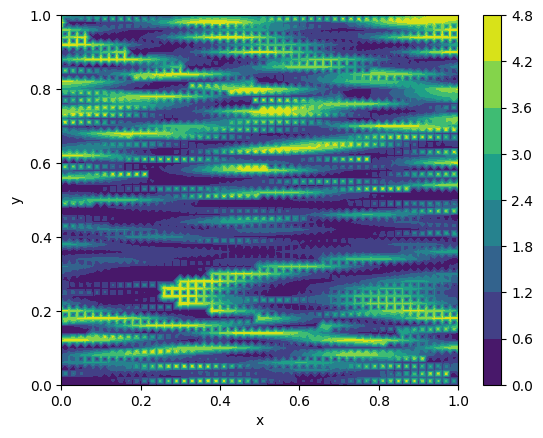

Code took 65 sec to run


In [ ]:
class TuringPattern(NonlinearProblem):

    def __init__(self, a, L):
        NonlinearProblem.__init__(self)
        self.L = L
        self.a = a

    def F(self, b, x):
        assemble(self.L, tensor=b)

    def J(self, A, x):
        assemble(self.a, tensor=A)


def f(u1, u2, a, b, gamma, d):
    return Constant(gamma)*(Constant(a) - u1 + u1*u1*u2)


def g(u1, u2, a, b, gamma, d):
    return Constant(gamma)*(Constant(b) - u1*u1*u2)


def simulate_schnackenberg_system(T, dt, tol, a, b, gamma, d):

    # Mesh and function space
    mesh = RectangleMesh(Point(0, 0), Point(1, 1), 50, 50, 'crossed')
    element = FiniteElement('P', triangle, 1)
    element_mixed = MixedElement([element, element])
    V = FunctionSpace(mesh, element_mixed)

    # Define trial and test functions
    du = TrialFunction(V)
    v = TestFunction(V)
    u = Function(V)
    u_old = Function(V)

    # Split mixed functions
    u1, u2 = split(u)
    u1_old, u2_old = split(u_old)

    # Initial conditions
    class IC(UserExpression):
        def eval(self, values, x):
            values[0] = a + b + 0.1*np.random.random()
            values[1] = b/((a+b)**2)
        def value_shape(self):
            return(2,)
    u_init = IC(element = V.ufl_element())
    u.interpolate(u_init)
    u_old.interpolate(u_init)

    # Define variational forms
    L0 = (u1 - u1_old)*v[0]*dx + dt*inner(grad(u1), grad(v[0]))*dx - dt*f(u1, u2, a, b, gamma, d)*v[0]*dx
    L1 = (u2 - u2_old)*v[1]*dx + dt*Constant(d)*inner(grad(u2), grad(v[1]))*dx - dt*g(u1, u2, a, b, gamma, d)*v[1]*dx
    L = L0 + L1
    a = derivative(L, u, du)

    # Create nonlinear problem and Newton solver
    problem = TuringPattern(a, L)
    solver = NewtonSolver()

    solver.parameters['maximum_iterations'] = 100

    # List to store nodal values at each time step
    u1_timecourse = []
    u2_timecourse = []

    # Time-stepping
    t = dt

    while t < T + DOLFIN_EPS:
        u_old.vector()[:] = u.vector()

        solver.solve(problem, u.vector())

        # # Check if the solution has reached a steady state, to within tol
        # change = sqrt(assemble((u_old - u)**2*dx))
        # if change < tol:
        #     print("Solution reached steady state at time", t)
        #     break

        # Store nodal values of u1 and u2 at current time step
        # u1_nodal_values, u2_nodal_values = u.split().vector().get_local()
        u1, u2 = u.split(True)
        u1_nodal_values = u1.vector().get_local()
        u2_nodal_values = u2.vector().get_local()
        u1_timecourse.append(u1_nodal_values)
        u2_timecourse.append(u2_nodal_values)

        # Move to next time step
        t += dt

    # Extract nodal values of u1 and u2 from the steady-state solution
    u1, u2 = u.split(True)
    u1_nodal_values = u1.vector().get_local()
    u2_nodal_values = u2.vector().get_local()

    # Extract the mesh coordinates and triangles
    mesh = u.function_space().mesh()
    x = mesh.coordinates()[:, 0]
    y = mesh.coordinates()[:, 1]
    triangles = np.asarray([cell.entities(0) for cell in cells(mesh)])

    # Create a tricontourf plot of u1 and u2
    plt.tricontourf(x, y, triangles, u1_nodal_values)
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

    return u1_nodal_values, u2_nodal_values, u1_timecourse, u2_timecourse

# Main code
t0 = time.time()

T = 1
dt = 0.005
tol = 1e-3
a, b, gamma, d = 0.02, 1.5, 920, 40


u1_nodal_values, u2_nodal_values, u1_timecourse, u2_timecourse = simulate_schnackenberg_system(T, dt, tol, a, b, gamma, d)
t1 = time.time()
print("Code took", int(t1 - t0), "sec to run")

u_sol = u1_nodal_values
v_sol = u2_nodal_values

## Fourier solving of Schnakenberg (2D - not working/forming patterns)

First we define the reaction-diffusion PDEs in the Fourier (kx, ky) space.

In [ ]:
def reaction_diffusion(t, uvt, K22, d1, d2, a, b, gamma, n, N):
    ut = np.reshape(uvt[:N], (n, n))
    vt = np.reshape(uvt[N : 2 * N], (n, n))
    u = np.real(ifft2(ut))
    v = np.real(ifft2(vt))

    utrhs = np.reshape((fft2(gamma*a - u + u*u * v)), (N, 1))
    vtrhs = np.reshape((fft2(gamma*b - u*u * v)), (N, 1))


    uvt_reshaped = np.reshape(uvt, (len(uvt), 1))
    uvt_updated = np.squeeze(
        np.vstack(
            (-d1 * K22 * uvt_reshaped[:N] + utrhs,
             -d2 * K22 * uvt_reshaped[N:] + vtrhs)
        )
    )
    return uvt_updated

We then generate some data to fit to.

In [ ]:
t = np.linspace(0, 10, int(10 / 0.05))
d1 = 1/100
d2 = 40/100


a, b, gamma, d = 0.02, 1.3, 30, 40

L = 20  # Domain size in X and Y directions
n = 256  # Number of spatial points in each direction
N = n * n
x_uniform = np.linspace(-L / 2, L / 2, n + 1)
x = x_uniform[:n]
y = x_uniform[:n]
n2 = int(n / 2)

We then define Fourier wavevectors (kx, ky)

In [ ]:
# Define Fourier wavevectors (kx, ky)
kx = (2 * np.pi / L) * np.hstack((np.linspace(0, n2 - 1, n2),
                                  np.linspace(-n2, -1, n2)))
ky = kx

# Get 2D meshes in (x, y) and (kx, ky)
X, Y = np.meshgrid(x, y)
KX, KY = np.meshgrid(kx, ky)
K2 = KX ** 2 + KY ** 2
K22 = np.reshape(K2, (N, 1))
m = 1  # number of spirals

# define our solution vectors
u = np.zeros((len(x), len(y), len(t)))
v = np.zeros((len(x), len(y), len(t)))

Initial conditions

In [ ]:
# # Initial conditions
# u[:, :, 0] = np.tanh(np.sqrt(X ** 2 + Y ** 2)) * np.cos(
#     m * np.angle(X + 1j * Y) - (np.sqrt(X ** 2 + Y ** 2))
# )
# v[:, :, 0] = np.tanh(np.sqrt(X ** 2 + Y ** 2)) * np.sin(
#     m * np.angle(X + 1j * Y) - (np.sqrt(X ** 2 + Y ** 2))
# )

# # Initial conditions
# u[:, :, 0] = (a + b) * np.random.random() + 1

# v[:, :, 0] = (b/((a+b)**2)) * np.random.random() + 1

# # Initial conditions
# u[:, :, 0] = (a + b) * np.random.normal(0, 0.1) + 1

# v[:, :, 0] = (b/((a+b)**2)) * np.random.normal(0, 0.1) + 1

# Initial conditions
u[:, :, 0] = (a + b) * np.random.normal(0, 0.1, u[:, :, 0].shape) + 0.1

v[:, :, 0] = (b/((a+b)**2)) * np.random.normal(0, 0.1, v[:,:,0].shape) + 0.1

In [ ]:
print(u[:,:, 0])

[[ 0.37821865  0.12721139  0.26322186 ... -0.02809722  0.00551935
   0.26300271]
 [ 0.17777803  0.20005491 -0.0410569  ... -0.03526572  0.1643043
   0.19453427]
 [-0.0507437  -0.19832111  0.16489305 ...  0.16170003  0.15863983
   0.21900266]
 ...
 [ 0.17434537  0.15032373  0.15444797 ...  0.04283661  0.24077103
   0.10223241]
 [ 0.16995837  0.1632987   0.15537812 ...  0.24552436  0.16281987
  -0.0305061 ]
 [ 0.07428033  0.15951492 -0.06215405 ...  0.09643085  0.13841694
   0.20537437]]


In [ ]:
# uvt is the solution vector in Fourier space, so below
# we are initializing the 2D FFT of the initial condition, uvt0
uvt0 = np.squeeze(
    np.hstack(
        (np.reshape(fft2(u[:, :, 0]), (1, N)),
         np.reshape(fft2(v[:, :, 0]), (1, N)))
    )
)

NameError: ignored

In [ ]:
# Solve the PDE in the Fourier space, where it reduces to system of ODEs
uvsol = solve_ivp(
    reaction_diffusion, (t[0], t[-1]), y0=uvt0, t_eval=t,
    args=(K22, d1, d2, a, b, gamma, n, N), **integrator_keywords
)
uvsol = uvsol.y

NameError: ignored

In [ ]:

# Reshape things and ifft back into (x, y, t) space from (kx, ky, t) space
for j in range(len(t)):
    ut = np.reshape(uvsol[:N, j], (n, n))
    vt = np.reshape(uvsol[N:, j], (n, n))
    u[:, :, j] = np.real(ifft2(ut))
    v[:, :, j] = np.real(ifft2(vt))

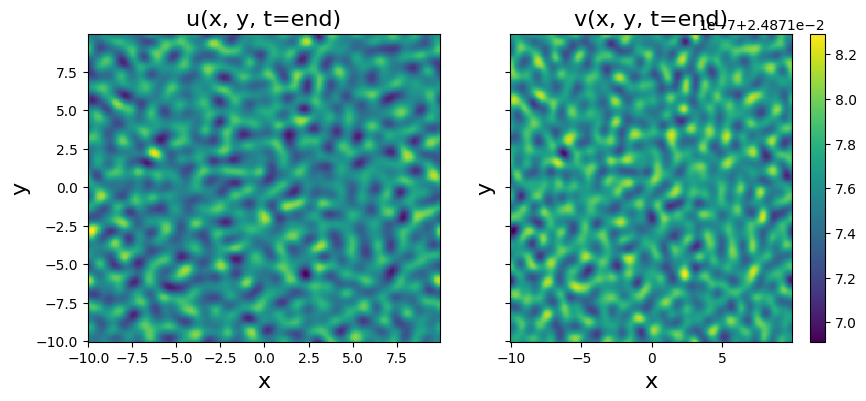

In [ ]:
# Plot to check if pattern is produces


plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.pcolor(X, Y, u[:, :, -1])
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.title('u(x, y, t=end)', fontsize=16)
plt.subplot(1, 2, 2)
plt.pcolor(X, Y, v[:, :, -1])
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title('v(x, y, t=end)', fontsize=16)
plt.colorbar()
dt = t[1] - t[0]
dx = x[1] - x[0]
dy = y[1] - y[0]

u_sol = u
v_sol = v

In [ ]:
print(dt)
print(dx)
print(dy)

0.05025125628140704
0.078125
0.078125


In [ ]:
print(u_sol[:,:,-1])

[[39.59852503 39.59852268 39.59852034 ... 39.59852759 39.59852785
  39.59852689]
 [39.59852389 39.59852173 39.59851954 ... 39.59852594 39.59852632
  39.59852555]
 [39.59852331 39.59852138 39.59851933 ... 39.59852467 39.59852521
  39.59852469]
 ...
 [39.59853059 39.598528   39.59852517 ... 39.59853277 39.59853332
  39.59853249]
 [39.59852847 39.5985259  39.59852324 ... 39.59853116 39.59853147
  39.59853047]
 [39.59852659 39.5985241  39.5985216  ... 39.59852939 39.59852962
  39.59852858]]


## Reshaping according to the PySINDy example

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
path = '/content/drive/MyDrive/Python_projects/EQL_Schnakenberg/'
os.chdir(path)

In [ ]:
u = load_array(path+ '/2D_Reaction_diffusion_example_soln_May-03-2023.pkl')
print(f"u_shape {u.shape}")

dt = 0.05
u_dot = ps.FiniteDifference(axis=2)._differentiate(u, dt)
print(f"u_dot shape {u_dot.shape}")

u_shape (128, 128, 200, 2)
u_dot shape (128, 128, 200, 2)


u is a vector containing an x and y value (both len 128), with 200 time points

In [ ]:
psindy_u = u
print(f"psindy_u_shape {psindy_u.shape}")

psindy_u_shape (128, 128, 200, 2)


In [ ]:
# Stacking the solutions of the 1D Schnakenberg system (this removes the list around the outside...)

u1_timecourse_stack = np.vstack(u1_timecourse)
u2_timecourse_stack = np.vstack(u2_timecourse)


print(f"u1_timecourse_shape {u1_timecourse_stack.shape}") # should be (11, 101)
print(f"u2_timecourse_shape {u2_timecourse_stack.shape}") # should be (11, 101)

# Reshaping to fit the style of the pSINDy example, i.e. (spatial_points, timepoints)
u1_timecourse_stack_reshaped = u1_timecourse_stack.reshape(101, 20000)
u2_timecourse_stack_reshaped = u2_timecourse_stack.reshape(101, 20000)

print(f"reshaped_u1_timecourse_shape {u1_timecourse_stack_reshaped.shape}") # should be (101, 20000)
print(f"reshaped_u2_timecourse_shape {u2_timecourse_stack_reshaped.shape}") # should be (101, 20000)

u1_timecourse_shape (20000, 101)
u2_timecourse_shape (20000, 101)
reshaped_u1_timecourse_shape (101, 20000)
reshaped_u2_timecourse_shape (101, 20000)


Each row in

```
u1/2_timecourse_stack_reshaped
```

 represents the solution at a particular spatial grid point over the 11 time points. For example, the first row contains the solution at the first spatial grid point over the 11 time points, and the last row contains the solution at the last spatial grid point over the 11 time points.

dx is 0.01, so the spatial grid has 100 points (L=1 in the Schnakenberg solver)

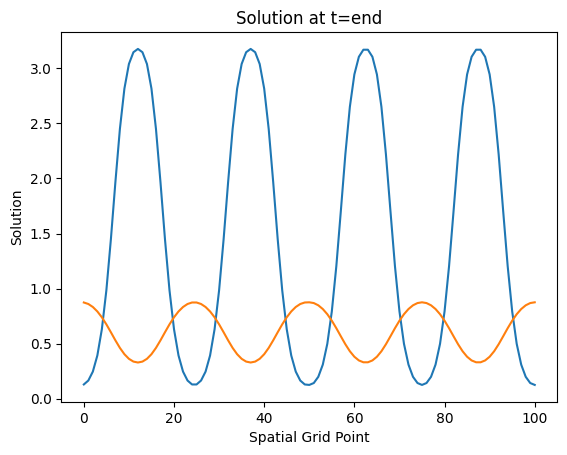

In [ ]:
plt.plot(u1_timecourse_stack_reshaped[:, -1])
plt.plot(u2_timecourse_stack_reshaped[:, -1])
plt.xlabel('Spatial Grid Point')
plt.ylabel('Solution')
plt.title('Solution at t=end')
plt.show()

In [ ]:
pysindy_t = np.linspace(0, 10, int(10/0.05))
print(pysindy_t.shape)
pysindy_dt = pysindy_t[1]-pysindy_t[0]
print(pysindy_dt)

(200,)
0.05025125628140704


In [ ]:
n = 101
t = np.linspace(0, T, int(T/0.05))
print(f"t.shape: {t.shape}")
dt = t[1] - t[0]
print(f"dt: {dt}")

t.shape: (2000,)
dt: 0.05002501250625312


Packaging up the two solutions to replicate the example

In [ ]:
u = np.zeros((n, 20000, 2))
u[:, :, 0] = u1_timecourse_stack_reshaped
u[:, :, 1] = u2_timecourse_stack_reshaped

print(f"u_sol shape {u[:,:,0].shape}")
print(f"v_sol shape {u[:,:,1].shape}")

array_save_path = os.path.join(path + 'solution.pkl')
u = save_solution(array_save_path, '1D_Schnakenberg_soln', u)
print(u.shape)

In [ ]:
u = load_array(path+ '/1D_Schnakenberg_soln_May-03-2023.pkl')

### Differentiating $u$

In [ ]:
u_dot = ps.FiniteDifference(axis=1)._differentiate(u, dt)

print(f"u_dot shape {u_dot[:,:,0].shape}")
print(f"v_dot shape {u_dot[:,:,1].shape}")

## The actual training

### Defining the library functions

In [ ]:
def build_library_and_train_model(u, u_dot, library_functions, library_function_names, spatial_grid, model_type,
                                   feature_names=["u", "v"], derivative_order=1, include_bias=True, is_uniform=True,
                                   periodic=True, threshold=0.01, alpha=0.5, normalize_columns=True, max_iter=2000):

    pde_lib = ps.PDELibrary(
        library_functions=library_functions,
        function_names=library_function_names,
        derivative_order=derivative_order,
        spatial_grid=spatial_grid,
        include_bias=include_bias,
        is_uniform=is_uniform,
        periodic=periodic,
    )

    print(f' model: {model_type}')

    if model_type == "STLSQ":
      optimizer = ps.STLSQ(
          threshold=threshold,
          alpha=alpha,
          normalize_columns=normalize_columns,
          max_iter=max_iter
      )

    model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer, feature_names=feature_names)
    model.fit(u, x_dot=u_dot)
    print(model.get_feature_names())
    model.print(lhs=['du_dt', 'dv_dt'])

    return model

In [ ]:
# polynomial library of order 3 (default?)
# Odd polynomial terms in (u, v), up to second order derivatives in (u, v)
library_functions = [
    lambda x: x,
    lambda x: x * x,
    lambda x, y: x * y * y,
    lambda x, y: x * x * y,

    # Schnakenberg RHS as a term
    # lambda x, y: x - x * x * y,
    # lambda x, y: -x + x * x * y
]
library_function_names = [
    lambda x: x,
    lambda x: x + x,
    lambda x, y: x + y + y,
    lambda x, y: x + x + y,

    # Schnakenberg RHS as a term
    # lambda x, y: x+x*x*y,
    # lambda x, y: -x + x*x*y
]

### Building and training with example data shapes (u_dot computed with PySINDy inbuild finite difference method)

In [ ]:
build_library_and_train_model(u, u_dot=None, library_functions=library_functions,
                              library_function_names=library_function_names,
                              spatial_grid=spatial_grid, #must have the same shape as u_sol
                              model_type="STLSQ",
                              feature_names=["u", "v"],
                              derivative_order=1,
                              include_bias=True,
                              is_uniform=True,
                              periodic=True,
                              threshold=0.1,
                              alpha=0.5,
                              normalize_columns=True,
                              max_iter=2000)


 model: STLSQ
['1', 'u', 'v', 'uu', 'vv', 'uvv', 'uuv', 'u_1', 'v_1', 'uu_1', 'uv_1', 'vu_1', 'vv_1', 'uuu_1', 'uuv_1', 'vvu_1', 'vvv_1', 'uvvu_1', 'uvvv_1', 'uuvu_1', 'uuvv_1']
du_dt = -0.218 u_1 + 0.618 v_1 + 0.047 uu_1 + 0.558 uv_1 + -0.002 vu_1 + -0.344 vv_1 + -0.082 uuu_1 + -0.009 uuv_1 + -0.254 vvu_1 + -1.300 vvv_1 + 0.029 uvvu_1 + 0.678 uvvv_1 + 0.299 uuvu_1 + 0.040 uuvv_1
dv_dt = 0.024 u_1 + 0.017 v_1 + -0.005 uu_1 + -0.057 uv_1 + 0.032 vv_1 + 0.008 uuu_1 + 0.001 uuv_1 + 0.013 vvu_1 + -0.035 vvv_1 + -0.004 uvvu_1 + 0.021 uvvv_1 + -0.026 uuvu_1 + 0.001 uuvv_1


SINDy(differentiation_method=FiniteDifference(axis=1),
      feature_library=<pysindy.feature_library.pde_library.PDELibrary object at 0x7f6dbedc1a20>,
      feature_names=['u', 'v'],
      optimizer=STLSQ(alpha=0.5, max_iter=2000, normalize_columns=True))

### Building and training with u_dot computed with separate psdindy step as per the 2D example)

In [ ]:
build_library_and_train_model(u, u_dot=u_dot, library_functions=library_functions,
                              library_function_names=library_function_names,
                              spatial_grid=spatial_grid, #must have the same shape as u_sol
                              model_type="STLSQ",
                              feature_names=["u", "v"],
                              derivative_order=1,
                              include_bias=True,
                              is_uniform=True,
                              periodic=True,
                              threshold=0.1,
                              alpha=0.5,
                              normalize_columns=True,
                              max_iter=2000)


 model: STLSQ
['1', 'u', 'v', 'uu', 'vv', 'uvv', 'uuv', 'u_1', 'v_1', 'uu_1', 'uv_1', 'vu_1', 'vv_1', 'uuu_1', 'uuv_1', 'vvu_1', 'vvv_1', 'uvvu_1', 'uvvv_1', 'uuvu_1', 'uuvv_1']
du_dt = 0.008 v + -0.008 vv + -0.004 uvv + -4.361 u_1 + 12.355 v_1 + 0.931 uu_1 + 11.144 uv_1 + -0.035 vu_1 + -6.885 vv_1 + -1.633 uuu_1 + -0.178 uuv_1 + -5.084 vvu_1 + -25.981 vvv_1 + 0.583 uvvu_1 + 13.549 uvvv_1 + 5.972 uuvu_1 + 0.796 uuvv_1
dv_dt = 0.476 u_1 + 0.347 v_1 + -0.103 uu_1 + -1.130 uv_1 + 0.002 vu_1 + 0.640 vv_1 + 0.151 uuu_1 + 0.025 uuv_1 + 0.262 vvu_1 + -0.692 vvv_1 + -0.079 uvvu_1 + 0.420 uvvv_1 + -0.522 uuvu_1 + 0.021 uuvv_1


SINDy(differentiation_method=FiniteDifference(axis=-2),
      feature_library=<pysindy.feature_library.pde_library.PDELibrary object at 0x7f6dc0e70880>,
      feature_names=['u', 'v'],
      optimizer=STLSQ(alpha=0.5, max_iter=2000, normalize_columns=True))

### Building and training with data shapes I made (u_dot computed with numpy.gradient)

In [ ]:
import numpy as np
t = np.linspace(0, T, int(T/0.05))
# Assuming that `u` is a 1D array of length 20000, and `t` is an array of time points
dt = t[1] - t[0]  # Time step size
u_t = np.gradient(u[:,:,0], dt, axis=0)
v_t = np.gradient(u[:,:,1], dt, axis=0)

print(f"u_sol shape {u[:,:,0].shape}")
print(f"v_sol shape {u[:,:,1].shape}")

print(f"u_t shape {u_t.shape}")
print(f"v_t shape {v_t.shape}")
print(f"spatial_grid shape {spatial_grid.shape}")

u_sol shape (101, 20000)
v_sol shape (101, 20000)
u_t shape (101, 20000)
v_t shape (101, 20000)
spatial_grid shape (101, 1)


In [ ]:
np.vstack(spatial_grid)

In [ ]:
spatial_grid_tiled = np.tile(spatial_grid, (20000))
print(f'spatial_grid shape {spatial_grid_tiled.shape}')

spatial_grid shape (101, 20000)


##### Fitting on just the u_solution, as a test (shapes easier to deal with)


In [ ]:
spatial_grid = np.vstack(spatial_grid)


In [ ]:
spatial_grid = spatial_grid.flatten()

In [ ]:
print(spatial_grid.shape)

(101,)


In [ ]:
print(spatial_grid_tiled.shape)

(101, 20000)


In [ ]:
build_library_and_train_model(u[:,:,0], u_dot=u_t, library_functions=library_functions,
                              library_function_names=library_function_names,
                              spatial_grid=spatial_grid, #must have the same shape as u_sol
                              model_type="STLSQ",
                              feature_names=["u", "v"],
                              derivative_order=1,
                              include_bias=False,
                              is_uniform=True,
                              periodic=True,
                              threshold=0.01,
                              alpha=0.5,
                              normalize_columns=True,
                              max_iter=2000)


$\frac{\partial u}{\partial t} = - 0.006u + 0.200\frac{\partial}{\partial x}^2u$

## Fitting on both the u and v solutions as above

Interestingly, the np.gradient computed derivatives seem to actually be able to be fit, compared to the inbuilt method above

In [ ]:
U = np.stack((u_sol, v_sol), axis=-1) # First column x, second y
U_T = np.stack((u_t, v_t), axis=-1)

In [ ]:
build_library_and_train_model(U, u_dot=U_T, library_functions=library_functions,
                              library_function_names=library_function_names,
                              spatial_grid=spatial_grid, #must have the same shape as u_sol
                              model_type="STLSQ",
                              feature_names=["u", "v"],
                              derivative_order=1,
                              include_bias=False,
                              is_uniform=True,
                              periodic=True,
                              threshold=0.1,
                              alpha=0.5,
                              normalize_columns=True,
                              max_iter=2000)


 model: STLSQ
['u', 'v', 'u_1', 'v_1', 'uu_1', 'uv_1', 'vu_1', 'vv_1']
du_dt = -0.007 u + 0.003 v + -0.075 u_1 + 6.305 v_1 + 0.017 uu_1 + 0.612 uv_1 + -1.098 vu_1 + -7.334 vv_1
dv_dt = -0.049 u_1 + 1.188 v_1 + 0.004 uu_1 + 0.105 uv_1 + -0.166 vu_1 + -1.141 vv_1


SINDy(differentiation_method=FiniteDifference(axis=-2),
      feature_library=<pysindy.feature_library.pde_library.PDELibrary object at 0x7f6d495795b0>,
      feature_names=['u', 'v'],
      optimizer=STLSQ(alpha=0.5, max_iter=2000, normalize_columns=True))

\begin{aligned}
\frac{\partial u}{\partial t} &= -0.007u + 0.003v -0.075\frac{\partial u}{\partial x} + 6.305\frac{\partial v}{\partial x} + 0.017u\frac{\partial u}{\partial x} + 0.612u\frac{\partial v}{\partial x} -1.098v\frac{\partial u}{\partial x} -7.334v\frac{\partial v}{\partial x} \\
\frac{\partial v}{\partial t} &= -0.049\frac{\partial u}{\partial x} + 1.188\frac{\partial v}{\partial x} + 0.004u\frac{\partial u}{\partial x} + 0.105u\frac{\partial v}{\partial x} -0.166v\frac{\partial u}{\partial x} -1.141v\frac{\partial v}{\partial x}
\end{aligned}

TODO

Check handling of timecourse for schnak
see how example does it

## WIP

Messing around with the library functions

In [ ]:
# polynomial library of order 3 (default?)
# Odd polynomial terms in (u, v), up to second order derivatives in (u, v)
library_functions = [
    # lambda x: x,
    lambda x: x * x * x,
    lambda x, y: x * y * y,
    lambda x, y: x * x * y,

    # # Schnakenberg RHS as a term
    # lambda x, y: x - x * x * y,
    # lambda x, y: -x + x * x * y
]
library_function_names = [
    # lambda x: x,
    lambda x: x + x + x,
    lambda x, y: x + y + y,
    lambda x, y: x + x + y,

    # # Schnakenberg RHS as a term
    # lambda x, y: x+x+x+y,
    # lambda x, y: -x + x+x+y
]

In [ ]:
build_library_and_train_model(U, u_dot=U_T, library_functions=library_functions,
                              library_function_names=library_function_names,
                              spatial_grid=spatial_grid, #must have the same shape as u_sol
                              model_type="STLSQ",
                              feature_names=["u", "v"],
                              derivative_order=1,
                              include_bias=False,
                              is_uniform=True,
                              periodic=True,
                              threshold=0.1,
                              alpha=0.5,
                              normalize_columns=True,
                              max_iter=2000)


 model: STLSQ
['uuu', 'vvv', 'uvv', 'uuv', 'u_1', 'v_1', 'uuuu_1', 'uuuv_1', 'vvvu_1', 'vvvv_1', 'uvvu_1', 'uvvv_1', 'uuvu_1', 'uuvv_1']
du_dt = -0.022 uvv + -0.271 u_1 + -4.949 v_1 + -0.005 uuuu_1 + -0.703 uuuv_1 + 0.183 vvvu_1 + 0.162 vvvv_1 + -0.080 uvvu_1 + 5.776 uvvv_1 + -3.506 uuvu_1 + 2.426 uuvv_1
dv_dt = 0.055 u_1 + 2.084 v_1 + 0.405 uuuv_1 + 0.031 vvvu_1 + -0.024 vvvv_1 + -2.492 uvvv_1 + -0.024 uuvu_1 + -0.467 uuvv_1


SINDy(differentiation_method=FiniteDifference(axis=-2),
      feature_library=<pysindy.feature_library.pde_library.PDELibrary object at 0x7f6d4963e790>,
      feature_names=['u', 'v'],
      optimizer=STLSQ(alpha=0.5, max_iter=2000, normalize_columns=True))

# Junk

In [ ]:
# polynomial library of order 3 (default?)
# Odd polynomial terms in (u, v), up to second order derivatives in (u, v)
library_functions = [
    lambda x: x,
    # lambda x: x * x * x,
    # lambda x, y: x * y * y,
    # lambda x, y: x * x * y,

    # Schnakenberg RHS as a term
    # lambda x, y: x - x * x * y,
    # lambda x, y: -x + x * x * y
]
library_function_names = [
    lambda x: x,
    # lambda x: x + x + x,
    # lambda x, y: x + y + y,
    # lambda x, y: x + x + y,

    # Schnakenberg RHS as a term
    # lambda x, y: x+x*x*y,
    # lambda x, y: -x + x*x*y
]

pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=1,
    spatial_grid=spatial_grid, #must have the same shape as u_sol
    include_bias=True,
    is_uniform=True,
    periodic=True,
    feature_names=["u", "v"]
)
print('STLSQ model: ')
optimizer = ps.STLSQ(threshold=0.01, alpha=0.5, # Changing threshold - lower admits more complex models, higher may mean that relevant terms are failed to be
                     normalize_columns=True, max_iter=2000)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, x_dot=u_dot)
model.get_feature_names()
model.print(lhs=['du_dt', 'dv_dt'])


pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=1,
    spatial_grid=spatial_grid, #must have the same shape as u_sol
    include_bias=True,
    is_uniform=True,
    periodic=True
    feature_names=["u", "v"]
)
print('STLSQ model: ')
optimizer = ps.STLSQ(threshold=1, alpha=0.5, # Changing threshold - lower admits more complex models, higher may mean that relevant terms are failed to be
                     normalize_columns=True, max_iter=2000)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u_sol, x_dot=u_t)
model.get_feature_names()
model.print(lhs=['du_dt', 'dv_dt']))




pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=1,
    spatial_grid=spatial_grid_dup, #must have the same shape as u_sol
    include_bias=True,
    is_uniform=True,
    periodic=True
    feature_names=["u", "v"]
)
print('STLSQ model: ')
optimizer = ps.STLSQ(threshold=1, alpha=0.5, # Changing threshold - lower admits more complex models, higher may mean that relevant terms are failed to be
                     normalize_columns=True, max_iter=2000)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u_sol_dup, x_dot=x_dot_dup)
model.get_feature_names())
model.print(lhs=['du_dt', 'dv_dt']))




SyntaxError: ignored

### Other model types to test

In [ ]:


# print('SR3 model, L0 norm: ')
# optimizer = ps.SR3(
#     threshold=60,
#     max_iter=1000,
#     tol=1e-10,
#     nu=1,
#     thresholder="l0",
#     normalize_columns=True,
# )
# model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
# model.fit(u_sol, x_dot=u_t)
# model.print()
# # u_dot_sr3 = model.predict(u_test)

# print('SR3 model, L1 norm: ')
# optimizer = ps.SR3(
#     threshold=40,
#     max_iter=1000,
#     tol=1e-10,
#     nu=1e2,
#     thresholder="l1",
#     normalize_columns=True,
# )
# model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
# model.fit(u_sol, x_dot=u_t)
# model.print()



In [ ]:
# u_sol = u1_nodal_values
# v_sol = u2_nodal_values
# t = np.linspace(0, 100, int(100/0.005))
# print(len(t))
# # Compute u_t from generated solution
# u = np.zeros((len(u_sol), len(v_sol), len(t), 2))
# print(u.shape)
# u[:, :, :, 0] = u_sol
# u[:, :, :, 1] = v_sol


# u_dot = ps.FiniteDifference(axis=2)._differentiate(u, dt)


u = np.zeros((n, n, len(t), 2))
u[:, :, :, 0] = u_sol
u[:, :, :, 1] = v_sol

# Choose 60 % of data for training because data is big...
# can only randomly subsample if you are passing u_dot to model.fit!!!
train = np.random.choice(len(t), int(len(t) * 0.6), replace=False)
test = [i for i in np.arange(len(t)) if i not in train]
u_train = u[:, :, train, :]
u_test = u[:, :, test, :]
u_dot_train = u_dot[:, :, train, :]
u_dot_test = u_dot[:, :, test, :]
t_train = t[train]
t_test = t[test]
spatial_grid = np.asarray([X, Y]).T

ValueError: ignored

In [ ]:
# polynomial library of order 3 (default?)
# Odd polynomial terms in (u, v), up to second order derivatives in (u, v)
library_functions = [
    lambda x: x,
    lambda x: x * x * x,
    lambda x, y: x * y * y,
    lambda x, y: x * x * y,
]
library_function_names = [
    lambda x: x,
    lambda x: x + x + x,
    lambda x, y: x + y + y,
    lambda x, y: x + x + y,
]
pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=2,
    spatial_grid=spatial_grid,
    include_bias=True,
    is_uniform=True,
    periodic=False
)
print('STLSQ model: ')
optimizer = ps.STLSQ(threshold=50, alpha=1e-5,
                     normalize_columns=True, max_iter=200)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u_train, x_dot=u_dot_train)
model.print()
u_dot_stlsq = model.predict(u_test)

print('SR3 model, L0 norm: ')
optimizer = ps.SR3(
    threshold=60,
    max_iter=1000,
    tol=1e-10,
    nu=1,
    thresholder="l0",
    normalize_columns=True,
)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u_sol, x_dot=u_dot_train)
# model.print()
# u_dot_sr3 = model.predict(u_test)

# print('SR3 model, L1 norm: ')
# optimizer = ps.SR3(
#     threshold=40,
#     max_iter=1000,
#     tol=1e-10,
#     nu=1e2,
#     thresholder="l1",
#     normalize_columns=True,
# )
# model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
# model.fit(u_train, x_dot=u_dot_train)
# model.print()

# print('Constrained SR3 model, L0 norm: ')
# feature_names = np.asarray(model.get_feature_names())
# n_features = len(feature_names)
# n_targets = u_train.shape[-1]
# constraint_rhs = np.zeros(2)
# constraint_lhs = np.zeros((2, n_targets * n_features))

# # (u_xx coefficient) - (u_yy coefficient) = 0
# constraint_lhs[0, 11] = 1
# constraint_lhs[0, 15] = -1
# # (v_xx coefficient) - (v_yy coefficient) = 0
# constraint_lhs[1, n_features + 11] = 1
# constraint_lhs[1, n_features + 15] = -1
# optimizer = ps.ConstrainedSR3(
#     threshold=.05,
#     max_iter=400,
#     tol=1e-10,
#     nu=1,
#     thresholder="l0",
#     normalize_columns=False,
#     constraint_rhs=constraint_rhs,
#     constraint_lhs=constraint_lhs,
# )
# model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
# model.fit(u_train, x_dot=u_dot_train)
# model.print()
# u_dot_constrained_sr3 = model.predict(u_test)


STLSQ model: 


NameError: ignored